<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/UNET_regression_demo.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/UNET_regression_demo.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# VIIRS High Resolution Nightlights Prediction 
with Landsat 8, Sentinel-2, and UNET

## To Do

Decide a model to Use
- [x] Figure out how to extract image patches for model training
- [x] Extract Sentinel 2 and Planet Data
- [x] Figure out which type of model to use
- [x] Figure out how to run one of these scripts  

Get a Demo Notebook Running
- [x] Get the notebook running locally with the tfrecords saved locally  
- [x] Train a model with small subset of the data  
- [x] Get the model prediction and inference code to run with local files
- [x] Get a simple version of the model trained  

Modify Notebook to Run with Nightlights
- [x] Substitute NLCD with nightlights  
- [x] Retrain a simple model with the new data  

Get the Model Running on the Lab Computer
- [x] Set up a python env on the lab computer  
- [x] Set up SSH on the lab computer
- [x] Adapt script to run on lab computer
- [x] Run on lab computer  

Improve the Model 
- [x] Visualize the model accuracy by epoch
- [x] Compare a prediction to the actual image
- [x] Create a difference image
- [ ] Scale up the model with original image patches
- [ ] Recreate image patches in Kenya
- [ ] Substitute Landsat 8 with Sentinel 2  
- [ ] Determine hyperparameters  

If Time Allows...
- [ ] Consider running again with Planet  
- [ ] Consider running again with a ViTs
- [ ] Look wealth instead of nightlights data  
- [ ] Look at effect of dataset size on model performance

# Introduction

This is an Earth Engine <> TensorFlow notebook.  Suppose you want to predict a continuous output (regression) from a stack of continuous inputs.  In this example, the output is VIIRS Day/Night Band from [VIIRS](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) and the input is a Landsat 8 composite.  The model is a [fully convolutional neural network (FCNN)](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf), specifically [U-net](https://arxiv.org/abs/1505.04597). In this notebook, we:

1.   Export train/test patches from Earth Engine, suitable for training an FCNN model.
2.   Preprocess the data. 
3.   Train and validating an FCNN model.
4.   Maki predictions with the trained model and import them to Earth Engine.

# Setup software libraries

Authenticate and import as necessary.

In [ ]:
# Read in the .env file
from dotenv import dotenv_values

# load env variables
config = dotenv_values(".env")

# set env variables
GCS_PROJECT = config['GCS_PROJECT']
BUCKET = config['BUCKET']
HOME_PATH = config['HOME_PATH']
DATA_PATH = config['DATA_PATH']
FOLDER = config['FOLDER']
GCLOUD_PATH = config['GCLOUD_PATH']


In [ ]:
# Cloud authentication when running in Colab
# Fix error: https://stackoverflow.com/questions/75666380/attributeerror-module-ipython-utils-traitlets-has-no-attribute-unicode
# from google.auth import auth
# import google
# auth.authenticate_user()

# Local authenticate when running locally
# ensure you have the Google Cloud SDK installed and configured
# !bash {GCLOUD_PATH}gcloud auth login --no-launch-browser
!{GCLOUD_PATH}gsutil lss

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

In [ ]:
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Folium setup.
import folium
print(folium.__version__)
# TODO substitude with geemap

# Variables

Declare the variables that will be in use throughout the notebook.

## Specify your Cloud Storage Bucket
You must have write access to a bucket to run this notebook

## Set other global variables

In [ ]:
# variables for image names
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']
BANDS = opticalBands + thermalBands
RESPONSE = 'avg_rad' ##### 
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 16000 # orignally 160000, use 800 for small version
EVAL_SIZE = 8000 # down 10X

# Specify model training parameters.
BATCH_SIZE = 64 # formerly 16
EPOCHS = 10
BUFFER_SIZE = 1000
OPTIMIZER = 'SGD'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

# Create and Stack Input + Target Imagery

Gather and setup the imagery to use for inputs (predictors).  This is a three-year, cloud-free, Landsat 8 composite.  Display it in the notebook for a sanity check.

In [ ]:
# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000).addBands(
          image.select(thermalBands).divide(10).clamp(273.15, 373.15)
            .subtract(273.15).divide(100)).updateMask(mask)

# The image input data is a cloud-masked median composite.
image = l8sr.filterDate('2021-01-01', '2022-12-31').map(maskL8sr).median()

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[-1, 37], zoom_start=8)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

mapid = image.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Prepare the response (what we want to predict).  This is nighttime brightness (in nanoWatts/sr/cm^2) from the VIIRS dataset.  Display to check.

In [ ]:
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad').filterDate('2021-01-01', '2022-12-31').median()
viirs = viirs.divide(5).float() # normalize to 0-1 range

mapid = viirs.getMapId({'min': 0, 'max': 1}) # normally max 1.0
map = folium.Map(location=[-1, 37], zoom_start=8)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='viirs dnb',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Stack the 2D images (Landsat composite and VIIRS DNB image) to create a single image from which samples can be taken.  Convert the image into an array image in which each pixel stores 256x256 patches of pixels for each band.  This is a key step that bears emphasis: to export training patches, convert a multi-band image to [an array image](https://developers.google.com/earth-engine/arrays_array_images#array-images) using [`neighborhoodToArray()`](https://developers.google.com/earth-engine/api_docs#eeimageneighborhoodtoarray), then sample the image at points.

In [ ]:
featureStack = ee.Image.cat([
  image.select(BANDS),
  viirs.select(RESPONSE)
]).float()

list = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(list, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)

# Define Training and Evaluation Areas
Use some pre-made geometries to sample the stack in strategic locations.  Specifically, these are hand-made polygons in which to take the 256x256 samples.  Display the sampling polygons on a map, red for training polygons, blue for evaluation.

In [ ]:
trainingPolys = ee.FeatureCollection('projects/google/DemoTrainingGeometries')
evalPolys = ee.FeatureCollection('projects/google/DemoEvalGeometries')
# trainingPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/trainingPolys')
# evalPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/evalPolys')
print(trainingPolys.getInfo())

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
map = folium.Map(location=[38., -100.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

# Sampling

The mapped data look reasonable so take a sample from each polygon and merge the results into a single export.  The key step is sampling the array image at points, to get all the pixels in a 256x256 neighborhood at each point.  It's worth noting that to build the training and testing data for the FCNN, you export a single TFRecord file that contains patches of pixel values in each record.  You do NOT need to export each training/testing patch to a different image.  Since each record potentially contains a lot of data (especially with big patches or many input bands), some manual sharding of the computation is necessary to avoid the `computed value too large` error.  Specifically, the following code takes multiple (smaller) samples within each geometry, merging the results to get a single export.

In [ ]:
# Convert the feature collections to lists for iteration.
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

# These numbers determined experimentally.
n = 200 # Number of shards in each polygon. # formerly 200
N = 2000 # Total sample size in each polygon. # formerly 2000


# Export Data to Cloud Storage
This can be modified to export to local storage, just adjust the file paths.

In [ ]:

# Export all the training data (in many pieces), with one task
# per geometry.
for g in range(trainingPolys.size().getInfo()):
  geomSample = ee.FeatureCollection([])
  for i in range(n):
    sample = arrays.sample(
      region = ee.Feature(trainingPolysList.get(g)).geometry(),
      scale = 30,
      numPixels = N / n, # Size of the shard.
      seed = i,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)
  
  desc = TRAINING_BASE + '_g' + str(g)
  print(g, FOLDER, BUCKET, desc)
  
  task = ee.batch.Export.table.toCloudStorage(
    collection = geomSample,
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + desc,
    fileFormat = 'TFRecord',
    selectors = BANDS + [RESPONSE]
  )
  task.start()
print('Training imagery tasks submitted. Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).')

In [ ]:

# Export all the evaluation data.
for g in range(evalPolys.size().getInfo()):
  geomSample = ee.FeatureCollection([])
  for i in range(n):
    sample = arrays.sample(
      region = ee.Feature(evalPolysList.get(g)).geometry(),
      scale = 30,
      numPixels = N / n,
      seed = i,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)

  desc = EVAL_BASE + '_g' + str(g)
  print(g, FOLDER, BUCKET, desc)
  
  task = ee.batch.Export.table.toCloudStorage(
    collection = geomSample,
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + desc,
    fileFormat = 'TFRecord',
    selectors = BANDS + [RESPONSE]
  )
  task.start()
print('Eval imagery tasks submitted. Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).')

# Copy Files from Cloud Storage to Local Storage
This is necessary to run the model locally. Run these here, or in the terminal to free up the Python kernel.

In [ ]:

# Copy from your bucket to local path (note -r is for recursive call)

# entire folder
!{GCLOUD_PATH}gsutil -m cp -r gs://csci5922-proj/viirs-usa ~/csci5922/proj/data

# single file
# !{GCLOUD_PATH}gsutil cp gs://$(BUCKET)/$(FOLDER)training_patches_g2.tfrecord.gz $(HOME_PATH)$(DATA_PATH)$(FOLDER)training_patches_g2.tfrecord.gz

## TODO move files to /local/isly9493 once permissions are given

# Training data

Load the data exported from Earth Engine into a `tf.data.Dataset`.  The following are helper functions for that.

In [ ]:
# from google.cloud import storage

def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(path, prefix, n_files):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  # original code
  # glob = tf.io.gfile.glob(pattern)
  
  # from the cloud
  # https://cloud.google.com/appengine/docs/legacy/standard/python/googlecloudstorageclient/read-write-to-cloud-storage
  # storage_client = storage.Client()
  # bucket = storage_client.get_bucket(BUCKET)
  # blobs = storage_client.list_blobs(BUCKET, prefix=pattern)
  # glob = []
  # for blob in blobs:
  #   globs.append(blob.name)
  # print(globs)
  # # append bucket name to globs
  # glob = ['gs://' + BUCKET + '/' + f for f in globs]

  # read local tfrecord.gz files from unet-mini
  glob = []
  for i in range(0, n_files):
    glob = path + prefix + '_g' + str(i) + '.tfrecord.gz'

  # glob = [
  #   '/home/isly9493/csci5922/proj/data/unet-mini/eval_patches_g0.tfrecord.gz',
  #   '/home/isly9493/csci5922/proj/data/unet-mini/eval_patches_g1.tfrecord.gz'
  # ]
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

Use the helpers to read in the training dataset.  Print the first record to check.

In [ ]:
# import os
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/ilyonsg/.config/gcloud/application_default_credentials.json"

def get_training_dataset():
	"""Get the preprocessed training dataset
  Returns:
    A tf.data.Dataset of training data.
  """
	# glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'
	dataset = get_dataset(HOME_PATH + DATA_PATH + FOLDER, TRAINING_BASE, 8) # change from 9 to 8
	dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
	return dataset

training = get_training_dataset()

# print(iter(training.take(1)).next())

# Evaluation data

Now do the same thing to get an evaluation dataset.  Note that unlike the training dataset, the evaluation dataset has a batch size of 1, is not repeated and is not shuffled.

In [ ]:
def get_eval_dataset():
	"""Get the preprocessed evaluation dataset
  Returns:
    A tf.data.Dataset of evaluation data.
  """	
	dataset = get_dataset(HOME_PATH + DATA_PATH + FOLDER, EVAL_BASE, 4)
	dataset = dataset.batch(1).repeat()
	return dataset

evaluation = get_eval_dataset()

# print(iter(evaluation.take(1)).next())

# Model

Here we use the Keras implementation of the U-Net model.  The U-Net model takes 256x256 pixel patches as input and outputs per-pixel class probability, label or a continuous output.  We can implement the model essentially unmodified, but will use mean squared error loss on the sigmoidal output since we are treating this as a regression problem, rather than a classification problem.  Since impervious surface fraction is constrained to [0,1], with many values close to zero or one, a saturating activation function is suitable here.

In [ ]:
from tensorflow import keras
from keras import layers
from keras import losses
from keras import models
from keras import metrics
from keras import optimizers

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder


def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[None, None, len(BANDS)]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get(OPTIMIZER),
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])

	return model

# Training the model

You train a Keras model by calling `.fit()` on it.  Here we're going to train for 10 epochs, which is suitable for demonstration purposes.  For production use, you probably want to optimize this parameter, for example through [hyperparamter tuning](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning).

In [ ]:
keras.backend.clear_session()
m = get_model()

Fit the model.

In [73]:
# fit the model
history = m.fit(
    x=training,
    epochs=50,
    # epochs=EPOCHS,
    steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE),
    validation_data=evaluation,
    validation_steps=EVAL_SIZE
)

Epoch 1/50


2023-12-08 19:11:18.906479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1968 of 2000
2023-12-08 19:11:19.072675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 32/250 [==>...........................] - ETA: 1:26 - loss: 6.6878 - root_mean_squared_error: 2.5861

2023-12-08 19:11:44.229686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1946 of 2000
2023-12-08 19:11:44.509227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 64/250 [======>.......................] - ETA: 1:44 - loss: 6.5888 - root_mean_squared_error: 2.5669

2023-12-08 19:12:06.754039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1945 of 2000
2023-12-08 19:12:07.039023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 96/250 [==========>...................] - ETA: 1:33 - loss: 6.5410 - root_mean_squared_error: 2.5575

2023-12-08 19:12:28.530408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1946 of 2000
2023-12-08 19:12:28.808849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


128/250 [==============>...............] - ETA: 1:16 - loss: 6.5115 - root_mean_squared_error: 2.5518

2023-12-08 19:12:48.682122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1942 of 2000
2023-12-08 19:12:48.983238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


160/250 [==================>...........] - ETA: 56s - loss: 6.4910 - root_mean_squared_error: 2.5477

2023-12-08 19:13:05.598371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1936 of 2000
2023-12-08 19:13:05.932509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


185/250 [=====================>........] - ETA: 40s - loss: 6.5418 - root_mean_squared_error: 2.5577

2023-12-08 19:13:16.132603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1928 of 2000


186/250 [=====================>........] - ETA: 39s - loss: 6.5308 - root_mean_squared_error: 2.5555

2023-12-08 19:13:16.507862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


216/250 [========================>.....] - ETA: 20s - loss: 6.5286 - root_mean_squared_error: 2.5551

2023-12-08 19:13:28.817864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1932 of 2000


217/250 [=========================>....] - ETA: 19s - loss: 6.5088 - root_mean_squared_error: 2.5512

2023-12-08 19:13:29.174451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


248/250 [============================>.] - ETA: 1s - loss: 6.4007 - root_mean_squared_error: 2.5300

2023-12-08 19:13:41.723169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


249/250 [============================>.] - ETA: 0s - loss: 6.3980 - root_mean_squared_error: 2.5294

2023-12-08 19:13:42.084241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 204s 760ms/step - loss: 6.4174 - root_mean_squared_error: 2.5332 - val_loss: 4.9898 - val_root_mean_squared_error: 2.2338
Epoch 2/50
 30/250 [==>...........................] - ETA: 1:28 - loss: 6.8518 - root_mean_squared_error: 2.6176

2023-12-08 19:14:43.351149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1913 of 2000


 31/250 [==>...........................] - ETA: 1:27 - loss: 6.7985 - root_mean_squared_error: 2.6074

2023-12-08 19:14:43.809748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 62/250 [======>.......................] - ETA: 1:15 - loss: 6.6549 - root_mean_squared_error: 2.5797

2023-12-08 19:14:56.210371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1902 of 2000


 64/250 [======>.......................] - ETA: 1:14 - loss: 6.6116 - root_mean_squared_error: 2.5713

2023-12-08 19:14:56.719267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 94/250 [==========>...................] - ETA: 1:02 - loss: 6.4951 - root_mean_squared_error: 2.5486

2023-12-08 19:15:09.085635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


 95/250 [==========>...................] - ETA: 1:02 - loss: 6.5057 - root_mean_squared_error: 2.5506

2023-12-08 19:15:09.526223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


126/250 [==============>...............] - ETA: 49s - loss: 6.4736 - root_mean_squared_error: 2.5443

2023-12-08 19:15:21.970087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1908 of 2000


127/250 [==============>...............] - ETA: 49s - loss: 6.4829 - root_mean_squared_error: 2.5462

2023-12-08 19:15:22.455705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


158/250 [=================>............] - ETA: 37s - loss: 6.4452 - root_mean_squared_error: 2.5387

2023-12-08 19:15:35.125152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1930 of 2000


159/250 [==================>...........] - ETA: 36s - loss: 6.4138 - root_mean_squared_error: 2.5325

2023-12-08 19:15:35.493875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


190/250 [=====================>........] - ETA: 24s - loss: 6.4722 - root_mean_squared_error: 2.5441

2023-12-08 19:15:48.045345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1940 of 2000


191/250 [=====================>........] - ETA: 23s - loss: 6.4705 - root_mean_squared_error: 2.5437

2023-12-08 19:15:48.353910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


222/250 [=========================>....] - ETA: 11s - loss: 6.4656 - root_mean_squared_error: 2.5427

2023-12-08 19:16:01.000878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1922 of 2000


223/250 [=========================>....] - ETA: 10s - loss: 6.4563 - root_mean_squared_error: 2.5409

2023-12-08 19:16:01.406486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.4518 - root_mean_squared_error: 2.5400

2023-12-08 19:16:14.006715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1897 of 2000
2023-12-08 19:16:14.607015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 599ms/step - loss: 6.4518 - root_mean_squared_error: 2.5400 - val_loss: 4.4612 - val_root_mean_squared_error: 2.1122
Epoch 3/50
 36/250 [===>..........................] - ETA: 1:26 - loss: 6.0665 - root_mean_squared_error: 2.4630

2023-12-08 19:17:15.314614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1937 of 2000


 37/250 [===>..........................] - ETA: 1:26 - loss: 5.9647 - root_mean_squared_error: 2.4423

2023-12-08 19:17:15.644988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 68/250 [=======>......................] - ETA: 1:13 - loss: 6.2522 - root_mean_squared_error: 2.5004

2023-12-08 19:17:28.370229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1948 of 2000


 69/250 [=======>......................] - ETA: 1:13 - loss: 6.2457 - root_mean_squared_error: 2.4991

2023-12-08 19:17:28.639023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


100/250 [===========>..................] - ETA: 1:01 - loss: 6.3306 - root_mean_squared_error: 2.5161

2023-12-08 19:17:41.472471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1955 of 2000


101/250 [===========>..................] - ETA: 1:00 - loss: 6.2791 - root_mean_squared_error: 2.5058

2023-12-08 19:17:41.707509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


132/250 [==============>...............] - ETA: 47s - loss: 6.3519 - root_mean_squared_error: 2.5203

2023-12-08 19:17:54.362877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


133/250 [==============>...............] - ETA: 47s - loss: 6.3430 - root_mean_squared_error: 2.5185

2023-12-08 19:17:54.688013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


164/250 [==================>...........] - ETA: 35s - loss: 6.3427 - root_mean_squared_error: 2.5185

2023-12-08 19:18:07.508303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1941 of 2000


165/250 [==================>...........] - ETA: 34s - loss: 6.3361 - root_mean_squared_error: 2.5172

2023-12-08 19:18:07.820919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


196/250 [======================>.......] - ETA: 21s - loss: 6.2842 - root_mean_squared_error: 2.5068

2023-12-08 19:18:20.406046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1913 of 2000


197/250 [======================>.......] - ETA: 21s - loss: 6.2760 - root_mean_squared_error: 2.5052

2023-12-08 19:18:20.858714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


228/250 [==========================>...] - ETA: 8s - loss: 6.3032 - root_mean_squared_error: 2.5106

2023-12-08 19:18:33.607329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


229/250 [==========================>...] - ETA: 8s - loss: 6.3003 - root_mean_squared_error: 2.5100

2023-12-08 19:18:33.957529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2192 - root_mean_squared_error: 2.4938

2023-12-08 19:18:46.546126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1845 of 2000
2023-12-08 19:18:47.435786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 151s 603ms/step - loss: 6.2192 - root_mean_squared_error: 2.4938 - val_loss: 4.4322 - val_root_mean_squared_error: 2.1053
Epoch 4/50
 42/250 [====>.........................] - ETA: 1:24 - loss: 6.5611 - root_mean_squared_error: 2.5615

2023-12-08 19:19:48.313991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


 43/250 [====>.........................] - ETA: 1:23 - loss: 6.5070 - root_mean_squared_error: 2.5509

2023-12-08 19:19:48.656502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 74/250 [=======>......................] - ETA: 1:10 - loss: 6.5891 - root_mean_squared_error: 2.5669

2023-12-08 19:20:01.169351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


 75/250 [========>.....................] - ETA: 1:10 - loss: 6.5683 - root_mean_squared_error: 2.5629

2023-12-08 19:20:01.515111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


106/250 [===========>..................] - ETA: 58s - loss: 6.4460 - root_mean_squared_error: 2.5389

2023-12-08 19:20:14.139497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1930 of 2000


107/250 [===========>..................] - ETA: 57s - loss: 6.4392 - root_mean_squared_error: 2.5375

2023-12-08 19:20:14.503638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


138/250 [===============>..............] - ETA: 45s - loss: 6.4860 - root_mean_squared_error: 2.5468

2023-12-08 19:20:27.205654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1927 of 2000


139/250 [===============>..............] - ETA: 44s - loss: 6.5071 - root_mean_squared_error: 2.5509

2023-12-08 19:20:27.585451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


170/250 [===================>..........] - ETA: 32s - loss: 6.4196 - root_mean_squared_error: 2.5337

2023-12-08 19:20:40.309397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1906 of 2000


171/250 [===================>..........] - ETA: 32s - loss: 6.4383 - root_mean_squared_error: 2.5374

2023-12-08 19:20:40.803877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


202/250 [=======================>......] - ETA: 19s - loss: 6.5228 - root_mean_squared_error: 2.5540

2023-12-08 19:20:53.213722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1908 of 2000


203/250 [=======================>......] - ETA: 19s - loss: 6.5342 - root_mean_squared_error: 2.5562

2023-12-08 19:20:53.699185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


234/250 [===========================>..] - ETA: 6s - loss: 6.4706 - root_mean_squared_error: 2.5437

2023-12-08 19:21:06.105923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1909 of 2000


235/250 [===========================>..] - ETA: 6s - loss: 6.4805 - root_mean_squared_error: 2.5457

2023-12-08 19:21:06.580392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.4306 - root_mean_squared_error: 2.5359

2023-12-08 19:21:19.171706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1770 of 2000
2023-12-08 19:21:20.510735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 599ms/step - loss: 6.4306 - root_mean_squared_error: 2.5359 - val_loss: 4.4235 - val_root_mean_squared_error: 2.1032
Epoch 5/50
 48/250 [====>.........................] - ETA: 1:22 - loss: 6.3399 - root_mean_squared_error: 2.5179

2023-12-08 19:22:20.476312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1942 of 2000


 49/250 [====>.........................] - ETA: 1:21 - loss: 6.2586 - root_mean_squared_error: 2.5017

2023-12-08 19:22:20.777567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 80/250 [========>.....................] - ETA: 1:08 - loss: 6.5298 - root_mean_squared_error: 2.5553

2023-12-08 19:22:33.360682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


 81/250 [========>.....................] - ETA: 1:08 - loss: 6.5503 - root_mean_squared_error: 2.5594

2023-12-08 19:22:33.703190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


112/250 [============>.................] - ETA: 55s - loss: 6.3773 - root_mean_squared_error: 2.5253

2023-12-08 19:22:46.293058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


113/250 [============>.................] - ETA: 55s - loss: 6.3815 - root_mean_squared_error: 2.5262

2023-12-08 19:22:46.640133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


144/250 [================>.............] - ETA: 42s - loss: 6.4415 - root_mean_squared_error: 2.5380

2023-12-08 19:22:59.197010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


145/250 [================>.............] - ETA: 42s - loss: 6.4050 - root_mean_squared_error: 2.5308

2023-12-08 19:22:59.524318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


176/250 [====================>.........] - ETA: 29s - loss: 6.4188 - root_mean_squared_error: 2.5335

2023-12-08 19:23:12.166925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1932 of 2000


177/250 [====================>.........] - ETA: 29s - loss: 6.4218 - root_mean_squared_error: 2.5341

2023-12-08 19:23:12.520699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


208/250 [=======================>......] - ETA: 16s - loss: 6.2787 - root_mean_squared_error: 2.5057

2023-12-08 19:23:25.088099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


209/250 [========================>.....] - ETA: 16s - loss: 6.2583 - root_mean_squared_error: 2.5017

2023-12-08 19:23:25.416376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


240/250 [===========================>..] - ETA: 4s - loss: 6.4406 - root_mean_squared_error: 2.5378

2023-12-08 19:23:38.014105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1930 of 2000


241/250 [===========================>..] - ETA: 3s - loss: 6.4204 - root_mean_squared_error: 2.5338

2023-12-08 19:23:38.377956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3580 - root_mean_squared_error: 2.5215

2023-12-08 19:23:50.950546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1776 of 2000
2023-12-08 19:23:52.236766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 599ms/step - loss: 6.3580 - root_mean_squared_error: 2.5215 - val_loss: 4.4103 - val_root_mean_squared_error: 2.1001
Epoch 6/50
 54/250 [=====>........................] - ETA: 1:19 - loss: 6.2036 - root_mean_squared_error: 2.4907

2023-12-08 19:24:52.453603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1939 of 2000


 55/250 [=====>........................] - ETA: 1:19 - loss: 6.1743 - root_mean_squared_error: 2.4848

2023-12-08 19:24:52.773528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 86/250 [=========>....................] - ETA: 1:06 - loss: 6.2443 - root_mean_squared_error: 2.4989

2023-12-08 19:25:05.335026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1932 of 2000


 87/250 [=========>....................] - ETA: 1:06 - loss: 6.3279 - root_mean_squared_error: 2.5155

2023-12-08 19:25:05.689135: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


118/250 [=============>................] - ETA: 53s - loss: 6.3992 - root_mean_squared_error: 2.5297

2023-12-08 19:25:18.292805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1936 of 2000


119/250 [=============>................] - ETA: 53s - loss: 6.4556 - root_mean_squared_error: 2.5408

2023-12-08 19:25:18.628853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


150/250 [=================>............] - ETA: 40s - loss: 6.3665 - root_mean_squared_error: 2.5232

2023-12-08 19:25:31.158256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1919 of 2000


151/250 [=================>............] - ETA: 40s - loss: 6.3470 - root_mean_squared_error: 2.5193

2023-12-08 19:25:31.586617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


182/250 [====================>.........] - ETA: 27s - loss: 6.3708 - root_mean_squared_error: 2.5240

2023-12-08 19:25:44.054438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


183/250 [====================>.........] - ETA: 27s - loss: 6.3590 - root_mean_squared_error: 2.5217

2023-12-08 19:25:44.488553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


214/250 [========================>.....] - ETA: 14s - loss: 6.3289 - root_mean_squared_error: 2.5157

2023-12-08 19:25:57.004895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


215/250 [========================>.....] - ETA: 14s - loss: 6.3423 - root_mean_squared_error: 2.5184

2023-12-08 19:25:57.353453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


246/250 [============================>.] - ETA: 1s - loss: 6.3796 - root_mean_squared_error: 2.5258

2023-12-08 19:26:09.915687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1912 of 2000


247/250 [============================>.] - ETA: 1s - loss: 6.3733 - root_mean_squared_error: 2.5245

2023-12-08 19:26:10.372929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 602ms/step - loss: 6.3851 - root_mean_squared_error: 2.5269 - val_loss: 4.4081 - val_root_mean_squared_error: 2.0996
Epoch 7/50
 28/250 [==>...........................] - ETA: 1:28 - loss: 5.9502 - root_mean_squared_error: 2.4393

2023-12-08 19:27:11.934280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1882 of 2000


 30/250 [==>...........................] - ETA: 1:27 - loss: 6.1464 - root_mean_squared_error: 2.4792

2023-12-08 19:27:12.553472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 60/250 [======>.......................] - ETA: 1:16 - loss: 6.3875 - root_mean_squared_error: 2.5274

2023-12-08 19:27:24.767121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1920 of 2000


 61/250 [======>.......................] - ETA: 1:15 - loss: 6.3348 - root_mean_squared_error: 2.5169

2023-12-08 19:27:25.186319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 92/250 [==========>...................] - ETA: 1:03 - loss: 6.3144 - root_mean_squared_error: 2.5128

2023-12-08 19:27:37.692829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1947 of 2000


 93/250 [==========>...................] - ETA: 1:03 - loss: 6.3089 - root_mean_squared_error: 2.5118

2023-12-08 19:27:37.967027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


124/250 [=============>................] - ETA: 50s - loss: 6.1882 - root_mean_squared_error: 2.4876

2023-12-08 19:27:50.570518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1935 of 2000


125/250 [==============>...............] - ETA: 50s - loss: 6.1830 - root_mean_squared_error: 2.4866

2023-12-08 19:27:50.914596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


156/250 [=================>............] - ETA: 37s - loss: 6.2656 - root_mean_squared_error: 2.5031

2023-12-08 19:28:03.472142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1930 of 2000


157/250 [=================>............] - ETA: 37s - loss: 6.2567 - root_mean_squared_error: 2.5013

2023-12-08 19:28:03.840130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


188/250 [=====================>........] - ETA: 24s - loss: 6.2431 - root_mean_squared_error: 2.4986

2023-12-08 19:28:16.393956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1937 of 2000


189/250 [=====================>........] - ETA: 24s - loss: 6.2620 - root_mean_squared_error: 2.5024

2023-12-08 19:28:16.722480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


220/250 [=========================>....] - ETA: 12s - loss: 6.3053 - root_mean_squared_error: 2.5110

2023-12-08 19:28:29.319505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1943 of 2000


221/250 [=========================>....] - ETA: 11s - loss: 6.2962 - root_mean_squared_error: 2.5092

2023-12-08 19:28:29.614918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2906 - root_mean_squared_error: 2.5081

2023-12-08 19:28:42.225876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1926 of 2000
2023-12-08 19:28:42.650248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.2906 - root_mean_squared_error: 2.5081 - val_loss: 4.4030 - val_root_mean_squared_error: 2.0983
Epoch 8/50
 34/250 [===>..........................] - ETA: 1:26 - loss: 6.0513 - root_mean_squared_error: 2.4599

2023-12-08 19:29:43.730488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


 35/250 [===>..........................] - ETA: 1:26 - loss: 6.2981 - root_mean_squared_error: 2.5096

2023-12-08 19:29:44.081682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 66/250 [======>.......................] - ETA: 1:14 - loss: 6.4377 - root_mean_squared_error: 2.5373

2023-12-08 19:29:56.595533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1942 of 2000


 67/250 [=======>......................] - ETA: 1:13 - loss: 6.5011 - root_mean_squared_error: 2.5497

2023-12-08 19:29:56.898799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 98/250 [==========>...................] - ETA: 1:01 - loss: 6.2917 - root_mean_squared_error: 2.5083

2023-12-08 19:30:09.476800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


 99/250 [==========>...................] - ETA: 1:00 - loss: 6.2565 - root_mean_squared_error: 2.5013

2023-12-08 19:30:09.826440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


130/250 [==============>...............] - ETA: 48s - loss: 6.3806 - root_mean_squared_error: 2.5260

2023-12-08 19:30:22.366286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1940 of 2000


131/250 [==============>...............] - ETA: 47s - loss: 6.3823 - root_mean_squared_error: 2.5263

2023-12-08 19:30:22.676247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


162/250 [==================>...........] - ETA: 35s - loss: 6.3740 - root_mean_squared_error: 2.5247

2023-12-08 19:30:35.262643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1913 of 2000


163/250 [==================>...........] - ETA: 35s - loss: 6.3529 - root_mean_squared_error: 2.5205

2023-12-08 19:30:35.717106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


194/250 [======================>.......] - ETA: 22s - loss: 6.3179 - root_mean_squared_error: 2.5136

2023-12-08 19:30:48.182450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1948 of 2000


195/250 [======================>.......] - ETA: 22s - loss: 6.3389 - root_mean_squared_error: 2.5177

2023-12-08 19:30:48.450053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


226/250 [==========================>...] - ETA: 9s - loss: 6.3188 - root_mean_squared_error: 2.5137 

2023-12-08 19:31:01.077906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


227/250 [==========================>...] - ETA: 9s - loss: 6.3064 - root_mean_squared_error: 2.5113

2023-12-08 19:31:01.504654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3642 - root_mean_squared_error: 2.5227

2023-12-08 19:31:14.065207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1866 of 2000
2023-12-08 19:31:14.831343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 596ms/step - loss: 6.3642 - root_mean_squared_error: 2.5227 - val_loss: 4.4006 - val_root_mean_squared_error: 2.0978
Epoch 9/50
 40/250 [===>..........................] - ETA: 1:24 - loss: 6.1173 - root_mean_squared_error: 2.4733

2023-12-08 19:32:14.999936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


 41/250 [===>..........................] - ETA: 1:24 - loss: 6.0091 - root_mean_squared_error: 2.4513

2023-12-08 19:32:15.438437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 72/250 [=======>......................] - ETA: 1:11 - loss: 6.5526 - root_mean_squared_error: 2.5598

2023-12-08 19:32:27.866910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1926 of 2000


 73/250 [=======>......................] - ETA: 1:11 - loss: 6.5144 - root_mean_squared_error: 2.5523

2023-12-08 19:32:28.249942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


104/250 [===========>..................] - ETA: 58s - loss: 6.3777 - root_mean_squared_error: 2.5254

2023-12-08 19:32:40.750674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1920 of 2000


105/250 [===========>..................] - ETA: 58s - loss: 6.3600 - root_mean_squared_error: 2.5219

2023-12-08 19:32:41.161187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


136/250 [===============>..............] - ETA: 45s - loss: 6.3769 - root_mean_squared_error: 2.5253

2023-12-08 19:32:53.646072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1939 of 2000


137/250 [===============>..............] - ETA: 45s - loss: 6.3457 - root_mean_squared_error: 2.5191

2023-12-08 19:32:53.966047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


168/250 [===================>..........] - ETA: 33s - loss: 6.3604 - root_mean_squared_error: 2.5220

2023-12-08 19:33:06.536940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1940 of 2000


169/250 [===================>..........] - ETA: 32s - loss: 6.3342 - root_mean_squared_error: 2.5168

2023-12-08 19:33:06.849597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


200/250 [=======================>......] - ETA: 20s - loss: 6.3387 - root_mean_squared_error: 2.5177

2023-12-08 19:33:19.414059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


201/250 [=======================>......] - ETA: 19s - loss: 6.3516 - root_mean_squared_error: 2.5202

2023-12-08 19:33:19.762970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


232/250 [==========================>...] - ETA: 7s - loss: 6.3726 - root_mean_squared_error: 2.5244

2023-12-08 19:33:32.330498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1932 of 2000


233/250 [==========================>...] - ETA: 6s - loss: 6.3626 - root_mean_squared_error: 2.5224

2023-12-08 19:33:32.683280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.4007 - root_mean_squared_error: 2.5300

2023-12-08 19:33:45.244213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1816 of 2000
2023-12-08 19:33:46.297723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 599ms/step - loss: 6.4007 - root_mean_squared_error: 2.5300 - val_loss: 4.3993 - val_root_mean_squared_error: 2.0974
Epoch 10/50
 46/250 [====>.........................] - ETA: 1:22 - loss: 5.8919 - root_mean_squared_error: 2.4273

2023-12-08 19:34:46.930211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


 47/250 [====>.........................] - ETA: 1:22 - loss: 6.1678 - root_mean_squared_error: 2.4835

2023-12-08 19:34:47.286510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 78/250 [========>.....................] - ETA: 1:09 - loss: 6.0142 - root_mean_squared_error: 2.4524

2023-12-08 19:34:59.851715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1905 of 2000


 79/250 [========>.....................] - ETA: 1:09 - loss: 6.0444 - root_mean_squared_error: 2.4585

2023-12-08 19:35:00.346529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


110/250 [============>.................] - ETA: 56s - loss: 6.1182 - root_mean_squared_error: 2.4735

2023-12-08 19:35:12.745103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


111/250 [============>.................] - ETA: 56s - loss: 6.0967 - root_mean_squared_error: 2.4692

2023-12-08 19:35:13.090393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


142/250 [================>.............] - ETA: 43s - loss: 6.2598 - root_mean_squared_error: 2.5020

2023-12-08 19:35:25.630693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1958 of 2000


143/250 [================>.............] - ETA: 43s - loss: 6.2404 - root_mean_squared_error: 2.4981

2023-12-08 19:35:25.847898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


174/250 [===================>..........] - ETA: 30s - loss: 6.2304 - root_mean_squared_error: 2.4961

2023-12-08 19:35:38.539383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1930 of 2000


175/250 [====================>.........] - ETA: 30s - loss: 6.2280 - root_mean_squared_error: 2.4956

2023-12-08 19:35:38.906544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


206/250 [=======================>......] - ETA: 17s - loss: 6.2163 - root_mean_squared_error: 2.4932

2023-12-08 19:35:51.432033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1927 of 2000


207/250 [=======================>......] - ETA: 17s - loss: 6.2262 - root_mean_squared_error: 2.4952

2023-12-08 19:35:51.813328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


238/250 [===========================>..] - ETA: 4s - loss: 6.2633 - root_mean_squared_error: 2.5027

2023-12-08 19:36:04.330602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


239/250 [===========================>..] - ETA: 4s - loss: 6.2474 - root_mean_squared_error: 2.4995

2023-12-08 19:36:04.654177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2258 - root_mean_squared_error: 2.4952

2023-12-08 19:36:17.254629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1763 of 2000
2023-12-08 19:36:18.614360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 597ms/step - loss: 6.2258 - root_mean_squared_error: 2.4952 - val_loss: 4.3958 - val_root_mean_squared_error: 2.0966
Epoch 11/50
 52/250 [=====>........................] - ETA: 1:20 - loss: 6.5879 - root_mean_squared_error: 2.5667

2023-12-08 19:37:18.550962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1935 of 2000


 53/250 [=====>........................] - ETA: 1:20 - loss: 6.5050 - root_mean_squared_error: 2.5505

2023-12-08 19:37:18.892272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 84/250 [=========>....................] - ETA: 1:07 - loss: 6.4787 - root_mean_squared_error: 2.5453

2023-12-08 19:37:31.409889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1936 of 2000


 85/250 [=========>....................] - ETA: 1:06 - loss: 6.4953 - root_mean_squared_error: 2.5486

2023-12-08 19:37:31.743210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


116/250 [============>.................] - ETA: 54s - loss: 6.4024 - root_mean_squared_error: 2.5303

2023-12-08 19:37:44.277320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1899 of 2000


118/250 [=============>................] - ETA: 53s - loss: 6.4033 - root_mean_squared_error: 2.5305

2023-12-08 19:37:44.809192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


148/250 [================>.............] - ETA: 41s - loss: 6.4247 - root_mean_squared_error: 2.5347

2023-12-08 19:37:57.160549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1914 of 2000


149/250 [================>.............] - ETA: 40s - loss: 6.4317 - root_mean_squared_error: 2.5361

2023-12-08 19:37:57.614061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


180/250 [====================>.........] - ETA: 28s - loss: 6.3498 - root_mean_squared_error: 2.5199

2023-12-08 19:38:10.033565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1932 of 2000


181/250 [====================>.........] - ETA: 27s - loss: 6.3607 - root_mean_squared_error: 2.5220

2023-12-08 19:38:10.384654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


212/250 [========================>.....] - ETA: 15s - loss: 6.4032 - root_mean_squared_error: 2.5305

2023-12-08 19:38:22.951062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1941 of 2000


213/250 [========================>.....] - ETA: 14s - loss: 6.3902 - root_mean_squared_error: 2.5279

2023-12-08 19:38:23.255202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


244/250 [============================>.] - ETA: 2s - loss: 6.4181 - root_mean_squared_error: 2.5334

2023-12-08 19:38:35.860242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1927 of 2000


245/250 [============================>.] - ETA: 2s - loss: 6.4072 - root_mean_squared_error: 2.5313

2023-12-08 19:38:36.239354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 599ms/step - loss: 6.3910 - root_mean_squared_error: 2.5280 - val_loss: 4.3932 - val_root_mean_squared_error: 2.0960
Epoch 12/50
 26/250 [==>...........................] - ETA: 1:29 - loss: 6.4633 - root_mean_squared_error: 2.5423

2023-12-08 19:39:37.441690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


 27/250 [==>...........................] - ETA: 1:28 - loss: 6.4619 - root_mean_squared_error: 2.5420

2023-12-08 19:39:37.794875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 58/250 [=====>........................] - ETA: 1:16 - loss: 6.3743 - root_mean_squared_error: 2.5247

2023-12-08 19:39:50.325180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1929 of 2000


 59/250 [======>.......................] - ETA: 1:16 - loss: 6.2998 - root_mean_squared_error: 2.5099

2023-12-08 19:39:50.699689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 90/250 [=========>....................] - ETA: 1:04 - loss: 6.3102 - root_mean_squared_error: 2.5120

2023-12-08 19:40:03.185679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1927 of 2000


 91/250 [=========>....................] - ETA: 1:03 - loss: 6.3032 - root_mean_squared_error: 2.5106

2023-12-08 19:40:03.568718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


122/250 [=============>................] - ETA: 51s - loss: 6.1787 - root_mean_squared_error: 2.4857

2023-12-08 19:40:16.057514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


123/250 [=============>................] - ETA: 51s - loss: 6.2005 - root_mean_squared_error: 2.4901

2023-12-08 19:40:16.408217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


154/250 [=================>............] - ETA: 38s - loss: 6.2782 - root_mean_squared_error: 2.5056

2023-12-08 19:40:28.938632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


155/250 [=================>............] - ETA: 38s - loss: 6.3226 - root_mean_squared_error: 2.5145

2023-12-08 19:40:29.287634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


186/250 [=====================>........] - ETA: 25s - loss: 6.3123 - root_mean_squared_error: 2.5124

2023-12-08 19:40:41.822231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1932 of 2000


187/250 [=====================>........] - ETA: 25s - loss: 6.2923 - root_mean_squared_error: 2.5084

2023-12-08 19:40:42.174207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


218/250 [=========================>....] - ETA: 12s - loss: 6.3738 - root_mean_squared_error: 2.5246

2023-12-08 19:40:54.726537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1939 of 2000


219/250 [=========================>....] - ETA: 12s - loss: 6.3628 - root_mean_squared_error: 2.5225

2023-12-08 19:40:55.046828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3046 - root_mean_squared_error: 2.5109

2023-12-08 19:41:07.620917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1936 of 2000
2023-12-08 19:41:07.993300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 597ms/step - loss: 6.3046 - root_mean_squared_error: 2.5109 - val_loss: 4.3949 - val_root_mean_squared_error: 2.0964
Epoch 13/50
 32/250 [==>...........................] - ETA: 1:27 - loss: 6.8698 - root_mean_squared_error: 2.6210

2023-12-08 19:42:09.055576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1922 of 2000


 33/250 [==>...........................] - ETA: 1:27 - loss: 6.9220 - root_mean_squared_error: 2.6310

2023-12-08 19:42:09.457827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 64/250 [======>.......................] - ETA: 1:14 - loss: 6.4948 - root_mean_squared_error: 2.5485

2023-12-08 19:42:21.905174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1928 of 2000


 65/250 [======>.......................] - ETA: 1:14 - loss: 6.4416 - root_mean_squared_error: 2.5380

2023-12-08 19:42:22.278724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 96/250 [==========>...................] - ETA: 1:01 - loss: 6.3402 - root_mean_squared_error: 2.5180

2023-12-08 19:42:34.750358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1914 of 2000


 97/250 [==========>...................] - ETA: 1:01 - loss: 6.3060 - root_mean_squared_error: 2.5112

2023-12-08 19:42:35.199453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


128/250 [==============>...............] - ETA: 49s - loss: 6.4396 - root_mean_squared_error: 2.5376

2023-12-08 19:42:47.727303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1904 of 2000


130/250 [==============>...............] - ETA: 48s - loss: 6.3842 - root_mean_squared_error: 2.5267

2023-12-08 19:42:48.231704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


160/250 [==================>...........] - ETA: 36s - loss: 6.3894 - root_mean_squared_error: 2.5277

2023-12-08 19:43:00.616526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1915 of 2000


161/250 [==================>...........] - ETA: 35s - loss: 6.4144 - root_mean_squared_error: 2.5327

2023-12-08 19:43:01.059793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


192/250 [======================>.......] - ETA: 23s - loss: 6.3483 - root_mean_squared_error: 2.5196

2023-12-08 19:43:13.510298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1927 of 2000


193/250 [======================>.......] - ETA: 22s - loss: 6.3412 - root_mean_squared_error: 2.5182

2023-12-08 19:43:13.885541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


224/250 [=========================>....] - ETA: 10s - loss: 6.3940 - root_mean_squared_error: 2.5286

2023-12-08 19:43:26.423655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


225/250 [==========================>...] - ETA: 10s - loss: 6.3860 - root_mean_squared_error: 2.5271

2023-12-08 19:43:26.781816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3409 - root_mean_squared_error: 2.5181

2023-12-08 19:43:39.331919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1854 of 2000
2023-12-08 19:43:40.167421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.3409 - root_mean_squared_error: 2.5181 - val_loss: 4.3916 - val_root_mean_squared_error: 2.0956
Epoch 14/50
 38/250 [===>..........................] - ETA: 1:25 - loss: 6.8369 - root_mean_squared_error: 2.6147

2023-12-08 19:44:40.973465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1900 of 2000


 40/250 [===>..........................] - ETA: 1:24 - loss: 6.5903 - root_mean_squared_error: 2.5672

2023-12-08 19:44:41.499399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 70/250 [=======>......................] - ETA: 1:12 - loss: 6.5155 - root_mean_squared_error: 2.5525

2023-12-08 19:44:53.956637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1912 of 2000


 71/250 [=======>......................] - ETA: 1:12 - loss: 6.4861 - root_mean_squared_error: 2.5468

2023-12-08 19:44:54.411126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


102/250 [===========>..................] - ETA: 59s - loss: 6.3287 - root_mean_squared_error: 2.5157 

2023-12-08 19:45:06.839340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1923 of 2000


103/250 [===========>..................] - ETA: 59s - loss: 6.3906 - root_mean_squared_error: 2.5280

2023-12-08 19:45:07.237439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


134/250 [===============>..............] - ETA: 46s - loss: 6.4382 - root_mean_squared_error: 2.5374

2023-12-08 19:45:19.751620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1913 of 2000


135/250 [===============>..............] - ETA: 46s - loss: 6.4087 - root_mean_squared_error: 2.5315

2023-12-08 19:45:20.204487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


166/250 [==================>...........] - ETA: 33s - loss: 6.2839 - root_mean_squared_error: 2.5068

2023-12-08 19:45:32.674371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1911 of 2000


167/250 [===================>..........] - ETA: 33s - loss: 6.3091 - root_mean_squared_error: 2.5118

2023-12-08 19:45:33.136317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


198/250 [======================>.......] - ETA: 21s - loss: 6.2937 - root_mean_squared_error: 2.5087

2023-12-08 19:45:45.613344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


199/250 [======================>.......] - ETA: 20s - loss: 6.2924 - root_mean_squared_error: 2.5085

2023-12-08 19:45:45.962282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


230/250 [==========================>...] - ETA: 8s - loss: 6.3634 - root_mean_squared_error: 2.5226

2023-12-08 19:45:58.522746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1896 of 2000


232/250 [==========================>...] - ETA: 7s - loss: 6.3291 - root_mean_squared_error: 2.5158

2023-12-08 19:45:59.067482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3586 - root_mean_squared_error: 2.5216

2023-12-08 19:46:11.437693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1796 of 2000
2023-12-08 19:46:12.627841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.3586 - root_mean_squared_error: 2.5216 - val_loss: 4.3928 - val_root_mean_squared_error: 2.0959
Epoch 15/50
 44/250 [====>.........................] - ETA: 1:23 - loss: 6.2556 - root_mean_squared_error: 2.5011

2023-12-08 19:47:12.859550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1889 of 2000


 46/250 [====>.........................] - ETA: 1:22 - loss: 6.2725 - root_mean_squared_error: 2.5045

2023-12-08 19:47:13.439841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 76/250 [========>.....................] - ETA: 1:10 - loss: 6.2641 - root_mean_squared_error: 2.5028

2023-12-08 19:47:25.720667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1941 of 2000


 77/250 [========>.....................] - ETA: 1:09 - loss: 6.2396 - root_mean_squared_error: 2.4979

2023-12-08 19:47:26.030881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


108/250 [===========>..................] - ETA: 57s - loss: 6.2886 - root_mean_squared_error: 2.5077

2023-12-08 19:47:38.589439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1912 of 2000


109/250 [============>.................] - ETA: 56s - loss: 6.3406 - root_mean_squared_error: 2.5181

2023-12-08 19:47:39.044420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


140/250 [===============>..............] - ETA: 44s - loss: 6.4803 - root_mean_squared_error: 2.5456

2023-12-08 19:47:51.495216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1909 of 2000


141/250 [===============>..............] - ETA: 43s - loss: 6.4575 - root_mean_squared_error: 2.5412

2023-12-08 19:47:51.975662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


172/250 [===================>..........] - ETA: 31s - loss: 6.2630 - root_mean_squared_error: 2.5026

2023-12-08 19:48:04.416521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1941 of 2000


173/250 [===================>..........] - ETA: 31s - loss: 6.2574 - root_mean_squared_error: 2.5015

2023-12-08 19:48:04.723713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


204/250 [=======================>......] - ETA: 18s - loss: 6.3707 - root_mean_squared_error: 2.5240

2023-12-08 19:48:17.365170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1944 of 2000


205/250 [=======================>......] - ETA: 18s - loss: 6.3511 - root_mean_squared_error: 2.5201

2023-12-08 19:48:17.653883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


236/250 [===========================>..] - ETA: 5s - loss: 6.2893 - root_mean_squared_error: 2.5078

2023-12-08 19:48:30.301702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1920 of 2000


237/250 [===========================>..] - ETA: 5s - loss: 6.2936 - root_mean_squared_error: 2.5087

2023-12-08 19:48:30.720508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3695 - root_mean_squared_error: 2.5238

2023-12-08 19:48:43.191647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1777 of 2000
2023-12-08 19:48:44.470024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.3695 - root_mean_squared_error: 2.5238 - val_loss: 4.3934 - val_root_mean_squared_error: 2.0960
Epoch 16/50
 50/250 [=====>........................] - ETA: 1:21 - loss: 6.2406 - root_mean_squared_error: 2.4981

2023-12-08 19:49:44.722801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1889 of 2000


 52/250 [=====>........................] - ETA: 1:20 - loss: 6.3159 - root_mean_squared_error: 2.5132

2023-12-08 19:49:45.299174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 82/250 [========>.....................] - ETA: 1:08 - loss: 6.3044 - root_mean_squared_error: 2.5108

2023-12-08 19:49:57.613057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1907 of 2000


 83/250 [========>.....................] - ETA: 1:07 - loss: 6.2855 - root_mean_squared_error: 2.5071

2023-12-08 19:49:58.098863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


114/250 [============>.................] - ETA: 55s - loss: 6.2528 - root_mean_squared_error: 2.5006

2023-12-08 19:50:10.495810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1940 of 2000


115/250 [============>.................] - ETA: 54s - loss: 6.2484 - root_mean_squared_error: 2.4997

2023-12-08 19:50:10.808869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


146/250 [================>.............] - ETA: 42s - loss: 6.2870 - root_mean_squared_error: 2.5074

2023-12-08 19:50:23.370622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1883 of 2000


148/250 [================>.............] - ETA: 41s - loss: 6.2672 - root_mean_squared_error: 2.5034

2023-12-08 19:50:23.985234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


178/250 [====================>.........] - ETA: 29s - loss: 6.2355 - root_mean_squared_error: 2.4971

2023-12-08 19:50:36.288647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1879 of 2000


180/250 [====================>.........] - ETA: 28s - loss: 6.2103 - root_mean_squared_error: 2.4920

2023-12-08 19:50:36.922887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


210/250 [========================>.....] - ETA: 16s - loss: 6.3474 - root_mean_squared_error: 2.5194

2023-12-08 19:50:49.233196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1941 of 2000


211/250 [========================>.....] - ETA: 15s - loss: 6.3524 - root_mean_squared_error: 2.5204

2023-12-08 19:50:49.537155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


242/250 [============================>.] - ETA: 3s - loss: 6.2801 - root_mean_squared_error: 2.5060

2023-12-08 19:51:02.162700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1886 of 2000


244/250 [============================>.] - ETA: 2s - loss: 6.3194 - root_mean_squared_error: 2.5138

2023-12-08 19:51:02.755304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 601ms/step - loss: 6.3024 - root_mean_squared_error: 2.5105 - val_loss: 4.4004 - val_root_mean_squared_error: 2.0977
Epoch 17/50
 24/250 [=>............................] - ETA: 1:33 - loss: 6.7530 - root_mean_squared_error: 2.5987

2023-12-08 19:52:04.278989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1923 of 2000


 25/250 [==>...........................] - ETA: 1:32 - loss: 6.6530 - root_mean_squared_error: 2.5793

2023-12-08 19:52:04.679665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 56/250 [=====>........................] - ETA: 1:18 - loss: 6.4049 - root_mean_squared_error: 2.5308

2023-12-08 19:52:17.200634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1890 of 2000


 58/250 [=====>........................] - ETA: 1:18 - loss: 6.4878 - root_mean_squared_error: 2.5471

2023-12-08 19:52:17.779361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 88/250 [=========>....................] - ETA: 1:05 - loss: 6.3416 - root_mean_squared_error: 2.5182

2023-12-08 19:52:30.097770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1885 of 2000


 90/250 [=========>....................] - ETA: 1:04 - loss: 6.3842 - root_mean_squared_error: 2.5267

2023-12-08 19:52:30.697531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


120/250 [=============>................] - ETA: 52s - loss: 6.3043 - root_mean_squared_error: 2.5108

2023-12-08 19:52:42.979525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


121/250 [=============>................] - ETA: 52s - loss: 6.2877 - root_mean_squared_error: 2.5075

2023-12-08 19:52:43.326256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


152/250 [=================>............] - ETA: 39s - loss: 6.3958 - root_mean_squared_error: 2.5290

2023-12-08 19:52:55.865490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


153/250 [=================>............] - ETA: 39s - loss: 6.3703 - root_mean_squared_error: 2.5239

2023-12-08 19:52:56.304700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


184/250 [=====================>........] - ETA: 26s - loss: 6.2963 - root_mean_squared_error: 2.5092

2023-12-08 19:53:08.748159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1943 of 2000


185/250 [=====================>........] - ETA: 26s - loss: 6.3211 - root_mean_squared_error: 2.5142

2023-12-08 19:53:09.044362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


216/250 [========================>.....] - ETA: 13s - loss: 6.3345 - root_mean_squared_error: 2.5168

2023-12-08 19:53:21.680466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1881 of 2000


218/250 [=========================>....] - ETA: 12s - loss: 6.3224 - root_mean_squared_error: 2.5144

2023-12-08 19:53:22.299287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


248/250 [============================>.] - ETA: 0s - loss: 6.2924 - root_mean_squared_error: 2.5085

2023-12-08 19:53:34.740400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


249/250 [============================>.] - ETA: 0s - loss: 6.3170 - root_mean_squared_error: 2.5134

2023-12-08 19:53:35.169610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 600ms/step - loss: 6.3282 - root_mean_squared_error: 2.5156 - val_loss: 4.3906 - val_root_mean_squared_error: 2.0954
Epoch 18/50
 30/250 [==>...........................] - ETA: 1:28 - loss: 6.1734 - root_mean_squared_error: 2.4846

2023-12-08 19:54:36.384219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1902 of 2000


 32/250 [==>...........................] - ETA: 1:27 - loss: 6.5414 - root_mean_squared_error: 2.5576

2023-12-08 19:54:36.895175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 62/250 [======>.......................] - ETA: 1:16 - loss: 6.4447 - root_mean_squared_error: 2.5386

2023-12-08 19:54:49.388590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1881 of 2000


 64/250 [======>.......................] - ETA: 1:15 - loss: 6.4176 - root_mean_squared_error: 2.5333

2023-12-08 19:54:50.010577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 94/250 [==========>...................] - ETA: 1:03 - loss: 6.3554 - root_mean_squared_error: 2.5210

2023-12-08 19:55:02.318225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1914 of 2000


 95/250 [==========>...................] - ETA: 1:02 - loss: 6.3949 - root_mean_squared_error: 2.5288

2023-12-08 19:55:02.767016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


126/250 [==============>...............] - ETA: 50s - loss: 6.3711 - root_mean_squared_error: 2.5241

2023-12-08 19:55:15.186359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1911 of 2000


127/250 [==============>...............] - ETA: 49s - loss: 6.3698 - root_mean_squared_error: 2.5239

2023-12-08 19:55:15.651031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


158/250 [=================>............] - ETA: 37s - loss: 6.4369 - root_mean_squared_error: 2.5371

2023-12-08 19:55:28.121381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1911 of 2000


159/250 [==================>...........] - ETA: 36s - loss: 6.4315 - root_mean_squared_error: 2.5360

2023-12-08 19:55:28.590053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


190/250 [=====================>........] - ETA: 24s - loss: 6.3721 - root_mean_squared_error: 2.5243

2023-12-08 19:55:41.045479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1880 of 2000


192/250 [======================>.......] - ETA: 23s - loss: 6.3624 - root_mean_squared_error: 2.5224

2023-12-08 19:55:41.668229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


222/250 [=========================>....] - ETA: 11s - loss: 6.3585 - root_mean_squared_error: 2.5216

2023-12-08 19:55:53.980132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1928 of 2000


223/250 [=========================>....] - ETA: 10s - loss: 6.3461 - root_mean_squared_error: 2.5191

2023-12-08 19:55:54.356749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3631 - root_mean_squared_error: 2.5225

2023-12-08 19:56:07.523139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1873 of 2000
2023-12-08 19:56:08.252061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 151s 606ms/step - loss: 6.3631 - root_mean_squared_error: 2.5225 - val_loss: 4.3920 - val_root_mean_squared_error: 2.0957
Epoch 19/50
 36/250 [===>..........................] - ETA: 1:26 - loss: 6.2236 - root_mean_squared_error: 2.4947

2023-12-08 19:57:10.319256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1925 of 2000


 37/250 [===>..........................] - ETA: 1:26 - loss: 6.3019 - root_mean_squared_error: 2.5104

2023-12-08 19:57:10.712059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 68/250 [=======>......................] - ETA: 1:13 - loss: 6.4044 - root_mean_squared_error: 2.5307

2023-12-08 19:57:23.213943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1942 of 2000


 69/250 [=======>......................] - ETA: 1:13 - loss: 6.4227 - root_mean_squared_error: 2.5343

2023-12-08 19:57:23.515698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


100/250 [===========>..................] - ETA: 1:00 - loss: 6.1669 - root_mean_squared_error: 2.4833

2023-12-08 19:57:36.106887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1923 of 2000


101/250 [===========>..................] - ETA: 1:00 - loss: 6.1534 - root_mean_squared_error: 2.4806

2023-12-08 19:57:36.509110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


132/250 [==============>...............] - ETA: 47s - loss: 6.2543 - root_mean_squared_error: 2.5009

2023-12-08 19:57:48.983665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1936 of 2000


133/250 [==============>...............] - ETA: 47s - loss: 6.2506 - root_mean_squared_error: 2.5001

2023-12-08 19:57:49.320474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


164/250 [==================>...........] - ETA: 34s - loss: 6.3063 - root_mean_squared_error: 2.5112

2023-12-08 19:58:01.851956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1919 of 2000


165/250 [==================>...........] - ETA: 34s - loss: 6.3299 - root_mean_squared_error: 2.5159

2023-12-08 19:58:02.274005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


196/250 [======================>.......] - ETA: 21s - loss: 6.2361 - root_mean_squared_error: 2.4972

2023-12-08 19:58:14.742743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1936 of 2000


197/250 [======================>.......] - ETA: 21s - loss: 6.2460 - root_mean_squared_error: 2.4992

2023-12-08 19:58:15.076466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


228/250 [==========================>...] - ETA: 8s - loss: 6.3137 - root_mean_squared_error: 2.5127

2023-12-08 19:58:27.646908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1929 of 2000


229/250 [==========================>...] - ETA: 8s - loss: 6.3062 - root_mean_squared_error: 2.5112

2023-12-08 19:58:28.017166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2926 - root_mean_squared_error: 2.5085

2023-12-08 19:58:40.565742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1840 of 2000
2023-12-08 19:58:41.479634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.2926 - root_mean_squared_error: 2.5085 - val_loss: 4.3891 - val_root_mean_squared_error: 2.0950
Epoch 20/50
 42/250 [====>.........................] - ETA: 1:24 - loss: 6.3837 - root_mean_squared_error: 2.5266

2023-12-08 19:59:41.997758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1948 of 2000


 43/250 [====>.........................] - ETA: 1:23 - loss: 6.3112 - root_mean_squared_error: 2.5122

2023-12-08 19:59:42.263889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 74/250 [=======>......................] - ETA: 1:11 - loss: 6.2753 - root_mean_squared_error: 2.5051

2023-12-08 19:59:54.865798: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


 75/250 [========>.....................] - ETA: 1:10 - loss: 6.2303 - root_mean_squared_error: 2.4961

2023-12-08 19:59:55.191822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


106/250 [===========>..................] - ETA: 58s - loss: 6.4014 - root_mean_squared_error: 2.5301

2023-12-08 20:00:07.734830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1929 of 2000


107/250 [===========>..................] - ETA: 57s - loss: 6.4511 - root_mean_squared_error: 2.5399

2023-12-08 20:00:08.108301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


138/250 [===============>..............] - ETA: 45s - loss: 6.3921 - root_mean_squared_error: 2.5283

2023-12-08 20:00:20.618913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1921 of 2000


139/250 [===============>..............] - ETA: 44s - loss: 6.3789 - root_mean_squared_error: 2.5256

2023-12-08 20:00:21.030295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


170/250 [===================>..........] - ETA: 32s - loss: 6.3584 - root_mean_squared_error: 2.5216

2023-12-08 20:00:33.520665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


171/250 [===================>..........] - ETA: 31s - loss: 6.3511 - root_mean_squared_error: 2.5201

2023-12-08 20:00:33.873038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


202/250 [=======================>......] - ETA: 19s - loss: 6.3208 - root_mean_squared_error: 2.5141

2023-12-08 20:00:46.416411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1943 of 2000


203/250 [=======================>......] - ETA: 18s - loss: 6.3173 - root_mean_squared_error: 2.5134

2023-12-08 20:00:46.712231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


234/250 [===========================>..] - ETA: 6s - loss: 6.3972 - root_mean_squared_error: 2.5293

2023-12-08 20:00:59.338530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


235/250 [===========================>..] - ETA: 6s - loss: 6.3999 - root_mean_squared_error: 2.5298

2023-12-08 20:00:59.662436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3411 - root_mean_squared_error: 2.5181

2023-12-08 20:01:12.248686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1799 of 2000
2023-12-08 20:01:13.398398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 597ms/step - loss: 6.3411 - root_mean_squared_error: 2.5181 - val_loss: 4.3910 - val_root_mean_squared_error: 2.0955
Epoch 21/50
 48/250 [====>.........................] - ETA: 1:22 - loss: 6.3199 - root_mean_squared_error: 2.5139

2023-12-08 20:02:13.647778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1926 of 2000


 49/250 [====>.........................] - ETA: 1:21 - loss: 6.2801 - root_mean_squared_error: 2.5060

2023-12-08 20:02:14.038573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 80/250 [========>.....................] - ETA: 1:08 - loss: 6.4067 - root_mean_squared_error: 2.5311

2023-12-08 20:02:26.515609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


 81/250 [========>.....................] - ETA: 1:08 - loss: 6.4557 - root_mean_squared_error: 2.5408

2023-12-08 20:02:26.863856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


112/250 [============>.................] - ETA: 55s - loss: 6.3361 - root_mean_squared_error: 2.5172

2023-12-08 20:02:39.384262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


113/250 [============>.................] - ETA: 55s - loss: 6.3277 - root_mean_squared_error: 2.5155

2023-12-08 20:02:39.747430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


144/250 [================>.............] - ETA: 42s - loss: 6.2911 - root_mean_squared_error: 2.5082

2023-12-08 20:02:52.234944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


145/250 [================>.............] - ETA: 42s - loss: 6.3091 - root_mean_squared_error: 2.5118

2023-12-08 20:02:52.584681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


176/250 [====================>.........] - ETA: 29s - loss: 6.3153 - root_mean_squared_error: 2.5130

2023-12-08 20:03:05.118500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


177/250 [====================>.........] - ETA: 29s - loss: 6.3619 - root_mean_squared_error: 2.5223

2023-12-08 20:03:05.468928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


208/250 [=======================>......] - ETA: 16s - loss: 6.3249 - root_mean_squared_error: 2.5149

2023-12-08 20:03:18.010949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1947 of 2000


209/250 [========================>.....] - ETA: 16s - loss: 6.2992 - root_mean_squared_error: 2.5098

2023-12-08 20:03:18.286087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


240/250 [===========================>..] - ETA: 4s - loss: 6.3517 - root_mean_squared_error: 2.5203

2023-12-08 20:03:30.930365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1929 of 2000


241/250 [===========================>..] - ETA: 3s - loss: 6.3539 - root_mean_squared_error: 2.5207

2023-12-08 20:03:31.298898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3253 - root_mean_squared_error: 2.5150

2023-12-08 20:03:43.823763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1749 of 2000
2023-12-08 20:03:45.268800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.3253 - root_mean_squared_error: 2.5150 - val_loss: 4.3901 - val_root_mean_squared_error: 2.0952
Epoch 22/50
 54/250 [=====>........................] - ETA: 1:19 - loss: 6.7675 - root_mean_squared_error: 2.6014

2023-12-08 20:04:45.529686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


 55/250 [=====>........................] - ETA: 1:19 - loss: 6.7466 - root_mean_squared_error: 2.5974

2023-12-08 20:04:45.960337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 86/250 [=========>....................] - ETA: 1:06 - loss: 6.2156 - root_mean_squared_error: 2.4931

2023-12-08 20:04:58.383472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


 87/250 [=========>....................] - ETA: 1:05 - loss: 6.2463 - root_mean_squared_error: 2.4993

2023-12-08 20:04:58.708111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


118/250 [=============>................] - ETA: 53s - loss: 6.4842 - root_mean_squared_error: 2.5464

2023-12-08 20:05:11.245158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1902 of 2000


120/250 [=============>................] - ETA: 52s - loss: 6.4190 - root_mean_squared_error: 2.5336

2023-12-08 20:05:11.754376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


150/250 [=================>............] - ETA: 40s - loss: 6.3599 - root_mean_squared_error: 2.5219

2023-12-08 20:05:24.115096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1926 of 2000


151/250 [=================>............] - ETA: 39s - loss: 6.3684 - root_mean_squared_error: 2.5236

2023-12-08 20:05:24.498863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


182/250 [====================>.........] - ETA: 27s - loss: 6.4016 - root_mean_squared_error: 2.5301

2023-12-08 20:05:36.995324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


183/250 [====================>.........] - ETA: 27s - loss: 6.3805 - root_mean_squared_error: 2.5260

2023-12-08 20:05:37.431182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


214/250 [========================>.....] - ETA: 14s - loss: 6.3677 - root_mean_squared_error: 2.5234

2023-12-08 20:05:49.892400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


215/250 [========================>.....] - ETA: 14s - loss: 6.3486 - root_mean_squared_error: 2.5196

2023-12-08 20:05:50.214245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


246/250 [============================>.] - ETA: 1s - loss: 6.3881 - root_mean_squared_error: 2.5275

2023-12-08 20:06:02.797188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1914 of 2000


247/250 [============================>.] - ETA: 1s - loss: 6.3748 - root_mean_squared_error: 2.5248

2023-12-08 20:06:03.244874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 599ms/step - loss: 6.3621 - root_mean_squared_error: 2.5223 - val_loss: 4.3898 - val_root_mean_squared_error: 2.0952
Epoch 23/50
 28/250 [==>...........................] - ETA: 1:28 - loss: 6.6287 - root_mean_squared_error: 2.5746

2023-12-08 20:07:04.299877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1937 of 2000


 29/250 [==>...........................] - ETA: 1:28 - loss: 6.6063 - root_mean_squared_error: 2.5703

2023-12-08 20:07:04.626127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 60/250 [======>.......................] - ETA: 1:16 - loss: 6.1090 - root_mean_squared_error: 2.4716

2023-12-08 20:07:17.152183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1928 of 2000


 61/250 [======>.......................] - ETA: 1:15 - loss: 6.1477 - root_mean_squared_error: 2.4795

2023-12-08 20:07:17.523831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 92/250 [==========>...................] - ETA: 1:03 - loss: 6.3067 - root_mean_squared_error: 2.5113

2023-12-08 20:07:30.006457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


 93/250 [==========>...................] - ETA: 1:03 - loss: 6.3017 - root_mean_squared_error: 2.5103

2023-12-08 20:07:30.350679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


124/250 [=============>................] - ETA: 50s - loss: 6.3526 - root_mean_squared_error: 2.5204

2023-12-08 20:07:42.881552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


125/250 [==============>...............] - ETA: 50s - loss: 6.3684 - root_mean_squared_error: 2.5236

2023-12-08 20:07:43.242412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


156/250 [=================>............] - ETA: 37s - loss: 6.3983 - root_mean_squared_error: 2.5295

2023-12-08 20:07:55.739670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


157/250 [=================>............] - ETA: 37s - loss: 6.3972 - root_mean_squared_error: 2.5293

2023-12-08 20:07:56.173702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


188/250 [=====================>........] - ETA: 24s - loss: 6.3379 - root_mean_squared_error: 2.5175

2023-12-08 20:08:08.642104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1928 of 2000


189/250 [=====================>........] - ETA: 24s - loss: 6.3350 - root_mean_squared_error: 2.5169

2023-12-08 20:08:09.013751: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


220/250 [=========================>....] - ETA: 12s - loss: 6.2813 - root_mean_squared_error: 2.5062

2023-12-08 20:08:21.565051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1905 of 2000


221/250 [=========================>....] - ETA: 11s - loss: 6.2656 - root_mean_squared_error: 2.5031

2023-12-08 20:08:22.056272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3169 - root_mean_squared_error: 2.5133

2023-12-08 20:08:34.518289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1905 of 2000
2023-12-08 20:08:35.065070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.3169 - root_mean_squared_error: 2.5133 - val_loss: 4.3890 - val_root_mean_squared_error: 2.0950
Epoch 24/50
 34/250 [===>..........................] - ETA: 1:26 - loss: 6.4676 - root_mean_squared_error: 2.5431

2023-12-08 20:09:36.161070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1927 of 2000


 35/250 [===>..........................] - ETA: 1:26 - loss: 6.5655 - root_mean_squared_error: 2.5623

2023-12-08 20:09:36.540477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 66/250 [======>.......................] - ETA: 1:13 - loss: 6.3301 - root_mean_squared_error: 2.5160

2023-12-08 20:09:49.019832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1944 of 2000


 67/250 [=======>......................] - ETA: 1:13 - loss: 6.3185 - root_mean_squared_error: 2.5137

2023-12-08 20:09:49.309970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 98/250 [==========>...................] - ETA: 1:01 - loss: 6.3379 - root_mean_squared_error: 2.5175

2023-12-08 20:10:01.868063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1942 of 2000


 99/250 [==========>...................] - ETA: 1:00 - loss: 6.3089 - root_mean_squared_error: 2.5118

2023-12-08 20:10:02.170910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


130/250 [==============>...............] - ETA: 48s - loss: 6.4472 - root_mean_squared_error: 2.5391

2023-12-08 20:10:14.737295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


131/250 [==============>...............] - ETA: 47s - loss: 6.4392 - root_mean_squared_error: 2.5375

2023-12-08 20:10:15.057957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


162/250 [==================>...........] - ETA: 35s - loss: 6.2775 - root_mean_squared_error: 2.5055

2023-12-08 20:10:27.630607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1947 of 2000


163/250 [==================>...........] - ETA: 35s - loss: 6.2763 - root_mean_squared_error: 2.5053

2023-12-08 20:10:27.907049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


194/250 [======================>.......] - ETA: 22s - loss: 6.3644 - root_mean_squared_error: 2.5228

2023-12-08 20:10:40.543066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1941 of 2000


195/250 [======================>.......] - ETA: 22s - loss: 6.3576 - root_mean_squared_error: 2.5214

2023-12-08 20:10:40.845671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


226/250 [==========================>...] - ETA: 9s - loss: 6.3319 - root_mean_squared_error: 2.5163 

2023-12-08 20:10:53.460949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1940 of 2000


227/250 [==========================>...] - ETA: 9s - loss: 6.3399 - root_mean_squared_error: 2.5179

2023-12-08 20:10:53.771359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2742 - root_mean_squared_error: 2.5048

2023-12-08 20:11:06.361150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1870 of 2000
2023-12-08 20:11:07.103126: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 597ms/step - loss: 6.2742 - root_mean_squared_error: 2.5048 - val_loss: 4.3968 - val_root_mean_squared_error: 2.0968
Epoch 25/50
 40/250 [===>..........................] - ETA: 1:24 - loss: 6.6877 - root_mean_squared_error: 2.5861

2023-12-08 20:12:07.740238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1932 of 2000


 41/250 [===>..........................] - ETA: 1:24 - loss: 6.6843 - root_mean_squared_error: 2.5854

2023-12-08 20:12:08.091903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 72/250 [=======>......................] - ETA: 1:11 - loss: 6.4874 - root_mean_squared_error: 2.5470

2023-12-08 20:12:20.594781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


 73/250 [=======>......................] - ETA: 1:11 - loss: 6.4658 - root_mean_squared_error: 2.5428

2023-12-08 20:12:20.943199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


104/250 [===========>..................] - ETA: 58s - loss: 6.5449 - root_mean_squared_error: 2.5583

2023-12-08 20:12:33.473396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1944 of 2000


105/250 [===========>..................] - ETA: 58s - loss: 6.6057 - root_mean_squared_error: 2.5702

2023-12-08 20:12:33.760806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


136/250 [===============>..............] - ETA: 45s - loss: 6.3984 - root_mean_squared_error: 2.5295

2023-12-08 20:12:46.348428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


137/250 [===============>..............] - ETA: 45s - loss: 6.4238 - root_mean_squared_error: 2.5345

2023-12-08 20:12:46.694703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


168/250 [===================>..........] - ETA: 33s - loss: 6.4983 - root_mean_squared_error: 2.5492

2023-12-08 20:12:59.242204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1937 of 2000


169/250 [===================>..........] - ETA: 32s - loss: 6.4738 - root_mean_squared_error: 2.5444

2023-12-08 20:12:59.571311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


200/250 [=======================>......] - ETA: 20s - loss: 6.4047 - root_mean_squared_error: 2.5308

2023-12-08 20:13:12.150063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


201/250 [=======================>......] - ETA: 19s - loss: 6.4071 - root_mean_squared_error: 2.5312

2023-12-08 20:13:12.491231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


232/250 [==========================>...] - ETA: 7s - loss: 6.4158 - root_mean_squared_error: 2.5329

2023-12-08 20:13:25.050394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1939 of 2000


233/250 [==========================>...] - ETA: 6s - loss: 6.4032 - root_mean_squared_error: 2.5304

2023-12-08 20:13:25.369416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3679 - root_mean_squared_error: 2.5235

2023-12-08 20:13:37.958286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1814 of 2000
2023-12-08 20:13:39.025550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 597ms/step - loss: 6.3679 - root_mean_squared_error: 2.5235 - val_loss: 4.3871 - val_root_mean_squared_error: 2.0945
Epoch 26/50
 46/250 [====>.........................] - ETA: 1:22 - loss: 6.3511 - root_mean_squared_error: 2.5201

2023-12-08 20:14:39.339617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1924 of 2000


 47/250 [====>.........................] - ETA: 1:22 - loss: 6.3923 - root_mean_squared_error: 2.5283

2023-12-08 20:14:39.734849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 78/250 [========>.....................] - ETA: 1:09 - loss: 6.3312 - root_mean_squared_error: 2.5162

2023-12-08 20:14:52.208399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1927 of 2000


 79/250 [========>.....................] - ETA: 1:09 - loss: 6.3051 - root_mean_squared_error: 2.5110

2023-12-08 20:14:52.583396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


110/250 [============>.................] - ETA: 56s - loss: 6.3744 - root_mean_squared_error: 2.5248

2023-12-08 20:15:05.090521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1915 of 2000


111/250 [============>.................] - ETA: 56s - loss: 6.3541 - root_mean_squared_error: 2.5207

2023-12-08 20:15:05.534535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


142/250 [================>.............] - ETA: 43s - loss: 6.3974 - root_mean_squared_error: 2.5293

2023-12-08 20:15:17.979848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1941 of 2000


143/250 [================>.............] - ETA: 43s - loss: 6.3989 - root_mean_squared_error: 2.5296

2023-12-08 20:15:18.283797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


174/250 [===================>..........] - ETA: 30s - loss: 6.3888 - root_mean_squared_error: 2.5276

2023-12-08 20:15:30.869566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1940 of 2000


175/250 [====================>.........] - ETA: 30s - loss: 6.4071 - root_mean_squared_error: 2.5312

2023-12-08 20:15:31.182277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


206/250 [=======================>......] - ETA: 17s - loss: 6.3582 - root_mean_squared_error: 2.5215

2023-12-08 20:15:43.759123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


207/250 [=======================>......] - ETA: 17s - loss: 6.3698 - root_mean_squared_error: 2.5238

2023-12-08 20:15:44.190924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


238/250 [===========================>..] - ETA: 4s - loss: 6.3601 - root_mean_squared_error: 2.5219

2023-12-08 20:15:56.657958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1923 of 2000


239/250 [===========================>..] - ETA: 4s - loss: 6.3597 - root_mean_squared_error: 2.5219

2023-12-08 20:15:57.060319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3573 - root_mean_squared_error: 2.5214

2023-12-08 20:16:09.559795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1754 of 2000
2023-12-08 20:16:10.971582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.3573 - root_mean_squared_error: 2.5214 - val_loss: 4.3872 - val_root_mean_squared_error: 2.0946
Epoch 27/50
 52/250 [=====>........................] - ETA: 1:20 - loss: 6.3759 - root_mean_squared_error: 2.5251

2023-12-08 20:17:11.081513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1938 of 2000


 53/250 [=====>........................] - ETA: 1:20 - loss: 6.4471 - root_mean_squared_error: 2.5391

2023-12-08 20:17:11.404697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 84/250 [=========>....................] - ETA: 1:07 - loss: 6.3643 - root_mean_squared_error: 2.5227

2023-12-08 20:17:23.963715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1937 of 2000


 85/250 [=========>....................] - ETA: 1:06 - loss: 6.4126 - root_mean_squared_error: 2.5323

2023-12-08 20:17:24.293523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


116/250 [============>.................] - ETA: 54s - loss: 6.3401 - root_mean_squared_error: 2.5180

2023-12-08 20:17:36.822816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


117/250 [=============>................] - ETA: 53s - loss: 6.3509 - root_mean_squared_error: 2.5201

2023-12-08 20:17:37.179411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


148/250 [================>.............] - ETA: 41s - loss: 6.2089 - root_mean_squared_error: 2.4918

2023-12-08 20:17:49.700153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1937 of 2000


149/250 [================>.............] - ETA: 40s - loss: 6.2188 - root_mean_squared_error: 2.4938

2023-12-08 20:17:50.028839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


180/250 [====================>.........] - ETA: 28s - loss: 6.3206 - root_mean_squared_error: 2.5141

2023-12-08 20:18:02.603851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1925 of 2000


181/250 [====================>.........] - ETA: 27s - loss: 6.3128 - root_mean_squared_error: 2.5125

2023-12-08 20:18:02.989219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


212/250 [========================>.....] - ETA: 15s - loss: 6.3441 - root_mean_squared_error: 2.5187

2023-12-08 20:18:15.520998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1943 of 2000


213/250 [========================>.....] - ETA: 14s - loss: 6.3562 - root_mean_squared_error: 2.5212

2023-12-08 20:18:15.818551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


244/250 [============================>.] - ETA: 2s - loss: 6.3776 - root_mean_squared_error: 2.5254

2023-12-08 20:18:28.401272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1943 of 2000


245/250 [============================>.] - ETA: 2s - loss: 6.3684 - root_mean_squared_error: 2.5236

2023-12-08 20:18:28.695882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.3507 - root_mean_squared_error: 2.5201 - val_loss: 4.3867 - val_root_mean_squared_error: 2.0944
Epoch 28/50
 26/250 [==>...........................] - ETA: 1:29 - loss: 6.0299 - root_mean_squared_error: 2.4556

2023-12-08 20:19:29.627725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


 27/250 [==>...........................] - ETA: 1:29 - loss: 6.1591 - root_mean_squared_error: 2.4818

2023-12-08 20:19:29.967570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 58/250 [=====>........................] - ETA: 1:16 - loss: 6.3070 - root_mean_squared_error: 2.5114

2023-12-08 20:19:42.506775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1950 of 2000


 59/250 [======>.......................] - ETA: 1:16 - loss: 6.3426 - root_mean_squared_error: 2.5185

2023-12-08 20:19:42.766683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 90/250 [=========>....................] - ETA: 1:04 - loss: 6.5280 - root_mean_squared_error: 2.5550

2023-12-08 20:19:55.378679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


 91/250 [=========>....................] - ETA: 1:03 - loss: 6.4730 - root_mean_squared_error: 2.5442

2023-12-08 20:19:55.719863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


122/250 [=============>................] - ETA: 51s - loss: 6.3134 - root_mean_squared_error: 2.5126

2023-12-08 20:20:08.244324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1898 of 2000


124/250 [=============>................] - ETA: 50s - loss: 6.2579 - root_mean_squared_error: 2.5016

2023-12-08 20:20:08.776166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


154/250 [=================>............] - ETA: 38s - loss: 6.3016 - root_mean_squared_error: 2.5103

2023-12-08 20:20:21.136838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1911 of 2000


155/250 [=================>............] - ETA: 38s - loss: 6.2844 - root_mean_squared_error: 2.5069

2023-12-08 20:20:21.594225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


186/250 [=====================>........] - ETA: 25s - loss: 6.3070 - root_mean_squared_error: 2.5114

2023-12-08 20:20:34.035913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1940 of 2000


187/250 [=====================>........] - ETA: 25s - loss: 6.3189 - root_mean_squared_error: 2.5137

2023-12-08 20:20:34.347266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


218/250 [=========================>....] - ETA: 12s - loss: 6.2910 - root_mean_squared_error: 2.5082

2023-12-08 20:20:46.936590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1941 of 2000


219/250 [=========================>....] - ETA: 12s - loss: 6.2897 - root_mean_squared_error: 2.5079

2023-12-08 20:20:47.241369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3410 - root_mean_squared_error: 2.5181

2023-12-08 20:20:59.858776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000
2023-12-08 20:21:00.240239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 597ms/step - loss: 6.3410 - root_mean_squared_error: 2.5181 - val_loss: 4.3863 - val_root_mean_squared_error: 2.0943
Epoch 29/50
 32/250 [==>...........................] - ETA: 1:27 - loss: 6.0029 - root_mean_squared_error: 2.4501

2023-12-08 20:22:01.217119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


 33/250 [==>...........................] - ETA: 1:27 - loss: 6.0128 - root_mean_squared_error: 2.4521

2023-12-08 20:22:01.575132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 64/250 [======>.......................] - ETA: 1:14 - loss: 6.0875 - root_mean_squared_error: 2.4673

2023-12-08 20:22:14.091663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1937 of 2000


 65/250 [======>.......................] - ETA: 1:14 - loss: 6.0099 - root_mean_squared_error: 2.4515

2023-12-08 20:22:14.417641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 96/250 [==========>...................] - ETA: 1:01 - loss: 6.2662 - root_mean_squared_error: 2.5032

2023-12-08 20:22:26.951702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1906 of 2000


 97/250 [==========>...................] - ETA: 1:01 - loss: 6.2629 - root_mean_squared_error: 2.5026

2023-12-08 20:22:27.432437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


128/250 [==============>...............] - ETA: 49s - loss: 6.3525 - root_mean_squared_error: 2.5204

2023-12-08 20:22:39.882017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1932 of 2000


129/250 [==============>...............] - ETA: 48s - loss: 6.3247 - root_mean_squared_error: 2.5149

2023-12-08 20:22:40.232645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


160/250 [==================>...........] - ETA: 36s - loss: 6.2961 - root_mean_squared_error: 2.5092

2023-12-08 20:22:52.789027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1923 of 2000


161/250 [==================>...........] - ETA: 35s - loss: 6.2889 - root_mean_squared_error: 2.5078

2023-12-08 20:22:53.183610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


192/250 [======================>.......] - ETA: 23s - loss: 6.3053 - root_mean_squared_error: 2.5110

2023-12-08 20:23:05.694273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1923 of 2000


193/250 [======================>.......] - ETA: 22s - loss: 6.2876 - root_mean_squared_error: 2.5075

2023-12-08 20:23:06.095369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


224/250 [=========================>....] - ETA: 10s - loss: 6.3275 - root_mean_squared_error: 2.5154

2023-12-08 20:23:18.580349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


225/250 [==========================>...] - ETA: 10s - loss: 6.3146 - root_mean_squared_error: 2.5129

2023-12-08 20:23:18.927131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3298 - root_mean_squared_error: 2.5159

2023-12-08 20:23:31.483443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1887 of 2000
2023-12-08 20:23:32.131288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.3298 - root_mean_squared_error: 2.5159 - val_loss: 4.3865 - val_root_mean_squared_error: 2.0944
Epoch 30/50
 38/250 [===>..........................] - ETA: 1:25 - loss: 6.0098 - root_mean_squared_error: 2.4515

2023-12-08 20:24:32.965899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1928 of 2000


 39/250 [===>..........................] - ETA: 1:25 - loss: 6.0689 - root_mean_squared_error: 2.4635

2023-12-08 20:24:33.339488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 70/250 [=======>......................] - ETA: 1:12 - loss: 6.2655 - root_mean_squared_error: 2.5031

2023-12-08 20:24:45.848820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1943 of 2000


 71/250 [=======>......................] - ETA: 1:12 - loss: 6.2209 - root_mean_squared_error: 2.4942

2023-12-08 20:24:46.143136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


102/250 [===========>..................] - ETA: 59s - loss: 6.2316 - root_mean_squared_error: 2.4963 

2023-12-08 20:24:58.725124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1889 of 2000


104/250 [===========>..................] - ETA: 58s - loss: 6.2833 - root_mean_squared_error: 2.5066

2023-12-08 20:24:59.292885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


134/250 [===============>..............] - ETA: 46s - loss: 6.3288 - root_mean_squared_error: 2.5157

2023-12-08 20:25:11.643966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


135/250 [===============>..............] - ETA: 46s - loss: 6.3158 - root_mean_squared_error: 2.5131

2023-12-08 20:25:11.982303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


166/250 [==================>...........] - ETA: 33s - loss: 6.2033 - root_mean_squared_error: 2.4906

2023-12-08 20:25:24.517946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1919 of 2000


167/250 [===================>..........] - ETA: 33s - loss: 6.2699 - root_mean_squared_error: 2.5040

2023-12-08 20:25:24.936424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


198/250 [======================>.......] - ETA: 20s - loss: 6.2316 - root_mean_squared_error: 2.4963

2023-12-08 20:25:37.433579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1918 of 2000


199/250 [======================>.......] - ETA: 20s - loss: 6.2795 - root_mean_squared_error: 2.5059

2023-12-08 20:25:37.852794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


230/250 [==========================>...] - ETA: 8s - loss: 6.3341 - root_mean_squared_error: 2.5168

2023-12-08 20:25:50.345833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1907 of 2000


231/250 [==========================>...] - ETA: 7s - loss: 6.3171 - root_mean_squared_error: 2.5134

2023-12-08 20:25:50.825499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2986 - root_mean_squared_error: 2.5097

2023-12-08 20:26:03.291841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1830 of 2000
2023-12-08 20:26:04.266989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 599ms/step - loss: 6.2986 - root_mean_squared_error: 2.5097 - val_loss: 4.3861 - val_root_mean_squared_error: 2.0943
Epoch 31/50
 44/250 [====>.........................] - ETA: 1:23 - loss: 6.0804 - root_mean_squared_error: 2.4658

2023-12-08 20:27:04.967185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1906 of 2000


 46/250 [====>.........................] - ETA: 1:22 - loss: 6.4600 - root_mean_squared_error: 2.5416

2023-12-08 20:27:05.456929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 76/250 [========>.....................] - ETA: 1:10 - loss: 6.1942 - root_mean_squared_error: 2.4888

2023-12-08 20:27:17.816920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


 77/250 [========>.....................] - ETA: 1:09 - loss: 6.2405 - root_mean_squared_error: 2.4981

2023-12-08 20:27:18.254834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


108/250 [===========>..................] - ETA: 57s - loss: 6.3647 - root_mean_squared_error: 2.5228

2023-12-08 20:27:30.685560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1937 of 2000


109/250 [============>.................] - ETA: 56s - loss: 6.3355 - root_mean_squared_error: 2.5170

2023-12-08 20:27:31.015957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


140/250 [===============>..............] - ETA: 44s - loss: 6.2803 - root_mean_squared_error: 2.5061

2023-12-08 20:27:43.553100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1892 of 2000


142/250 [================>.............] - ETA: 43s - loss: 6.2951 - root_mean_squared_error: 2.5090

2023-12-08 20:27:44.113093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


172/250 [===================>..........] - ETA: 31s - loss: 6.2928 - root_mean_squared_error: 2.5085

2023-12-08 20:27:56.468117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1921 of 2000


173/250 [===================>..........] - ETA: 31s - loss: 6.3201 - root_mean_squared_error: 2.5140

2023-12-08 20:27:56.876907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


204/250 [=======================>......] - ETA: 18s - loss: 6.3593 - root_mean_squared_error: 2.5218

2023-12-08 20:28:09.355054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


205/250 [=======================>......] - ETA: 18s - loss: 6.3446 - root_mean_squared_error: 2.5189

2023-12-08 20:28:09.793775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


236/250 [===========================>..] - ETA: 5s - loss: 6.3510 - root_mean_squared_error: 2.5201

2023-12-08 20:28:22.269383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1910 of 2000


237/250 [===========================>..] - ETA: 5s - loss: 6.3450 - root_mean_squared_error: 2.5189

2023-12-08 20:28:22.739704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2816 - root_mean_squared_error: 2.5063

2023-12-08 20:28:35.171203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1775 of 2000
2023-12-08 20:28:36.465520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 596ms/step - loss: 6.2816 - root_mean_squared_error: 2.5063 - val_loss: 4.3845 - val_root_mean_squared_error: 2.0939
Epoch 32/50
 50/250 [=====>........................] - ETA: 1:21 - loss: 6.6707 - root_mean_squared_error: 2.5828

2023-12-08 20:29:36.392446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1912 of 2000


 51/250 [=====>........................] - ETA: 1:20 - loss: 6.7209 - root_mean_squared_error: 2.5925

2023-12-08 20:29:36.851432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 82/250 [========>.....................] - ETA: 1:07 - loss: 6.4572 - root_mean_squared_error: 2.5411

2023-12-08 20:29:49.256620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1910 of 2000


 83/250 [========>.....................] - ETA: 1:07 - loss: 6.4395 - root_mean_squared_error: 2.5376

2023-12-08 20:29:49.729348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


114/250 [============>.................] - ETA: 54s - loss: 6.4091 - root_mean_squared_error: 2.5316

2023-12-08 20:30:02.132023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1942 of 2000


115/250 [============>.................] - ETA: 54s - loss: 6.3966 - root_mean_squared_error: 2.5292

2023-12-08 20:30:02.433480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


146/250 [================>.............] - ETA: 41s - loss: 6.4525 - root_mean_squared_error: 2.5402

2023-12-08 20:30:15.006991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


147/250 [================>.............] - ETA: 41s - loss: 6.4275 - root_mean_squared_error: 2.5352

2023-12-08 20:30:15.436079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


178/250 [====================>.........] - ETA: 29s - loss: 6.4180 - root_mean_squared_error: 2.5334

2023-12-08 20:30:27.892379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1905 of 2000


180/250 [====================>.........] - ETA: 28s - loss: 6.4425 - root_mean_squared_error: 2.5382

2023-12-08 20:30:28.388284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


210/250 [========================>.....] - ETA: 16s - loss: 6.4430 - root_mean_squared_error: 2.5383

2023-12-08 20:30:40.766972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1943 of 2000


211/250 [========================>.....] - ETA: 15s - loss: 6.4283 - root_mean_squared_error: 2.5354

2023-12-08 20:30:41.060964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


242/250 [============================>.] - ETA: 3s - loss: 6.3851 - root_mean_squared_error: 2.5269

2023-12-08 20:30:53.649528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1909 of 2000


243/250 [============================>.] - ETA: 2s - loss: 6.3656 - root_mean_squared_error: 2.5230

2023-12-08 20:30:54.125163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 596ms/step - loss: 6.3812 - root_mean_squared_error: 2.5261 - val_loss: 4.3849 - val_root_mean_squared_error: 2.0940
Epoch 33/50
 24/250 [=>............................] - ETA: 1:33 - loss: 6.4673 - root_mean_squared_error: 2.5431

2023-12-08 20:31:54.847521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1879 of 2000


 26/250 [==>...........................] - ETA: 1:32 - loss: 6.6912 - root_mean_squared_error: 2.5867

2023-12-08 20:31:55.473038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 56/250 [=====>........................] - ETA: 1:18 - loss: 6.3548 - root_mean_squared_error: 2.5209

2023-12-08 20:32:07.777650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1910 of 2000


 57/250 [=====>........................] - ETA: 1:18 - loss: 6.3575 - root_mean_squared_error: 2.5214

2023-12-08 20:32:08.246246: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 88/250 [=========>....................] - ETA: 1:05 - loss: 6.3239 - root_mean_squared_error: 2.5147

2023-12-08 20:32:20.650689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1894 of 2000


 90/250 [=========>....................] - ETA: 1:04 - loss: 6.3544 - root_mean_squared_error: 2.5208

2023-12-08 20:32:21.205609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


120/250 [=============>................] - ETA: 52s - loss: 6.4221 - root_mean_squared_error: 2.5342

2023-12-08 20:32:33.531972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1890 of 2000


122/250 [=============>................] - ETA: 51s - loss: 6.4007 - root_mean_squared_error: 2.5300

2023-12-08 20:32:34.108728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


152/250 [=================>............] - ETA: 39s - loss: 6.2811 - root_mean_squared_error: 2.5062

2023-12-08 20:32:46.448048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1895 of 2000


154/250 [=================>............] - ETA: 38s - loss: 6.2712 - root_mean_squared_error: 2.5042

2023-12-08 20:32:47.004891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


184/250 [=====================>........] - ETA: 26s - loss: 6.3550 - root_mean_squared_error: 2.5209

2023-12-08 20:32:59.347587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1871 of 2000


186/250 [=====================>........] - ETA: 25s - loss: 6.3539 - root_mean_squared_error: 2.5207

2023-12-08 20:33:00.023244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


216/250 [========================>.....] - ETA: 13s - loss: 6.3241 - root_mean_squared_error: 2.5148

2023-12-08 20:33:12.274654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1866 of 2000


218/250 [=========================>....] - ETA: 12s - loss: 6.3610 - root_mean_squared_error: 2.5221

2023-12-08 20:33:12.976757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


248/250 [============================>.] - ETA: 0s - loss: 6.3770 - root_mean_squared_error: 2.5253

2023-12-08 20:33:25.231958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1893 of 2000


250/250 [==============================] - ETA: 0s - loss: 6.3652 - root_mean_squared_error: 2.5229

2023-12-08 20:33:25.792901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 599ms/step - loss: 6.3652 - root_mean_squared_error: 2.5229 - val_loss: 4.3834 - val_root_mean_squared_error: 2.0936
Epoch 34/50
 30/250 [==>...........................] - ETA: 1:28 - loss: 6.5432 - root_mean_squared_error: 2.5580

2023-12-08 20:34:26.558520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1913 of 2000


 31/250 [==>...........................] - ETA: 1:27 - loss: 6.4023 - root_mean_squared_error: 2.5303

2023-12-08 20:34:27.005274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 62/250 [======>.......................] - ETA: 1:15 - loss: 6.3206 - root_mean_squared_error: 2.5141

2023-12-08 20:34:39.450700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


 63/250 [======>.......................] - ETA: 1:15 - loss: 6.2980 - root_mean_squared_error: 2.5096

2023-12-08 20:34:39.888731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 94/250 [==========>...................] - ETA: 1:02 - loss: 6.1837 - root_mean_squared_error: 2.4867

2023-12-08 20:34:52.312635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1902 of 2000


 96/250 [==========>...................] - ETA: 1:01 - loss: 6.2190 - root_mean_squared_error: 2.4938

2023-12-08 20:34:52.825747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


126/250 [==============>...............] - ETA: 49s - loss: 6.2436 - root_mean_squared_error: 2.4987

2023-12-08 20:35:05.181700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1906 of 2000


127/250 [==============>...............] - ETA: 49s - loss: 6.2527 - root_mean_squared_error: 2.5005

2023-12-08 20:35:05.664132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


158/250 [=================>............] - ETA: 37s - loss: 6.2220 - root_mean_squared_error: 2.4944

2023-12-08 20:35:18.091991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1864 of 2000


160/250 [==================>...........] - ETA: 36s - loss: 6.2464 - root_mean_squared_error: 2.4993

2023-12-08 20:35:18.804125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


190/250 [=====================>........] - ETA: 24s - loss: 6.2676 - root_mean_squared_error: 2.5035

2023-12-08 20:35:31.035323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1948 of 2000


191/250 [=====================>........] - ETA: 23s - loss: 6.2822 - root_mean_squared_error: 2.5064

2023-12-08 20:35:31.301004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


222/250 [=========================>....] - ETA: 11s - loss: 6.3106 - root_mean_squared_error: 2.5121

2023-12-08 20:35:43.943920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1900 of 2000


224/250 [=========================>....] - ETA: 10s - loss: 6.2621 - root_mean_squared_error: 2.5024

2023-12-08 20:35:44.462761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2978 - root_mean_squared_error: 2.5095

2023-12-08 20:35:56.854129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1847 of 2000
2023-12-08 20:35:57.731509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.2978 - root_mean_squared_error: 2.5095 - val_loss: 4.3851 - val_root_mean_squared_error: 2.0941
Epoch 35/50
 36/250 [===>..........................] - ETA: 1:26 - loss: 6.6357 - root_mean_squared_error: 2.5760

2023-12-08 20:36:58.352124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1910 of 2000


 37/250 [===>..........................] - ETA: 1:26 - loss: 6.5489 - root_mean_squared_error: 2.5591

2023-12-08 20:36:58.816697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 68/250 [=======>......................] - ETA: 1:13 - loss: 6.5020 - root_mean_squared_error: 2.5499

2023-12-08 20:37:11.216452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1876 of 2000


 70/250 [=======>......................] - ETA: 1:12 - loss: 6.4279 - root_mean_squared_error: 2.5353

2023-12-08 20:37:11.858687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


100/250 [===========>..................] - ETA: 1:00 - loss: 6.3443 - root_mean_squared_error: 2.5188

2023-12-08 20:37:24.158585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1902 of 2000


102/250 [===========>..................] - ETA: 59s - loss: 6.2909 - root_mean_squared_error: 2.5082 

2023-12-08 20:37:24.667545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


132/250 [==============>...............] - ETA: 47s - loss: 6.2554 - root_mean_squared_error: 2.5011

2023-12-08 20:37:37.027299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1906 of 2000


134/250 [===============>..............] - ETA: 46s - loss: 6.3112 - root_mean_squared_error: 2.5122

2023-12-08 20:37:37.517279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


164/250 [==================>...........] - ETA: 34s - loss: 6.3801 - root_mean_squared_error: 2.5259

2023-12-08 20:37:49.903431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1862 of 2000


166/250 [==================>...........] - ETA: 33s - loss: 6.3368 - root_mean_squared_error: 2.5173

2023-12-08 20:37:50.614226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


196/250 [======================>.......] - ETA: 21s - loss: 6.3167 - root_mean_squared_error: 2.5133

2023-12-08 20:38:02.839321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1914 of 2000


197/250 [======================>.......] - ETA: 21s - loss: 6.3030 - root_mean_squared_error: 2.5106

2023-12-08 20:38:03.279085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


228/250 [==========================>...] - ETA: 8s - loss: 6.3690 - root_mean_squared_error: 2.5237

2023-12-08 20:38:15.773396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1920 of 2000


229/250 [==========================>...] - ETA: 8s - loss: 6.3480 - root_mean_squared_error: 2.5195

2023-12-08 20:38:16.191179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3498 - root_mean_squared_error: 2.5199

2023-12-08 20:38:28.669010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1831 of 2000
2023-12-08 20:38:29.652123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 597ms/step - loss: 6.3498 - root_mean_squared_error: 2.5199 - val_loss: 4.3835 - val_root_mean_squared_error: 2.0937
Epoch 36/50
 42/250 [====>.........................] - ETA: 1:24 - loss: 6.1212 - root_mean_squared_error: 2.4741

2023-12-08 20:39:29.910544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1913 of 2000


 43/250 [====>.........................] - ETA: 1:23 - loss: 6.0864 - root_mean_squared_error: 2.4671

2023-12-08 20:39:30.363993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 74/250 [=======>......................] - ETA: 1:11 - loss: 6.2796 - root_mean_squared_error: 2.5059

2023-12-08 20:39:42.771085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


 75/250 [========>.....................] - ETA: 1:10 - loss: 6.3436 - root_mean_squared_error: 2.5186

2023-12-08 20:39:43.127982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


106/250 [===========>..................] - ETA: 58s - loss: 6.2141 - root_mean_squared_error: 2.4928

2023-12-08 20:39:55.664904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1911 of 2000


107/250 [===========>..................] - ETA: 57s - loss: 6.1961 - root_mean_squared_error: 2.4892

2023-12-08 20:39:56.125233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


138/250 [===============>..............] - ETA: 45s - loss: 6.1903 - root_mean_squared_error: 2.4880

2023-12-08 20:40:08.584064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1920 of 2000


139/250 [===============>..............] - ETA: 44s - loss: 6.1774 - root_mean_squared_error: 2.4854

2023-12-08 20:40:09.001725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


170/250 [===================>..........] - ETA: 32s - loss: 6.2036 - root_mean_squared_error: 2.4907

2023-12-08 20:40:21.470771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


171/250 [===================>..........] - ETA: 31s - loss: 6.1984 - root_mean_squared_error: 2.4897

2023-12-08 20:40:21.826706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


202/250 [=======================>......] - ETA: 19s - loss: 6.3438 - root_mean_squared_error: 2.5187

2023-12-08 20:40:34.370414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1926 of 2000


203/250 [=======================>......] - ETA: 18s - loss: 6.3312 - root_mean_squared_error: 2.5162

2023-12-08 20:40:34.756683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


234/250 [===========================>..] - ETA: 6s - loss: 6.3003 - root_mean_squared_error: 2.5100

2023-12-08 20:40:47.269101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1913 of 2000


235/250 [===========================>..] - ETA: 6s - loss: 6.3219 - root_mean_squared_error: 2.5143

2023-12-08 20:40:47.721634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2897 - root_mean_squared_error: 2.5079

2023-12-08 20:41:00.192192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1782 of 2000
2023-12-08 20:41:01.401800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 600ms/step - loss: 6.2897 - root_mean_squared_error: 2.5079 - val_loss: 4.3833 - val_root_mean_squared_error: 2.0936
Epoch 37/50
 48/250 [====>.........................] - ETA: 1:22 - loss: 6.6114 - root_mean_squared_error: 2.5713

2023-12-08 20:42:02.307273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1928 of 2000


 49/250 [====>.........................] - ETA: 1:21 - loss: 6.5126 - root_mean_squared_error: 2.5520

2023-12-08 20:42:02.676230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 80/250 [========>.....................] - ETA: 1:08 - loss: 6.3071 - root_mean_squared_error: 2.5114

2023-12-08 20:42:15.163320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1877 of 2000


 82/250 [========>.....................] - ETA: 1:07 - loss: 6.3051 - root_mean_squared_error: 2.5110

2023-12-08 20:42:15.807472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


112/250 [============>.................] - ETA: 55s - loss: 6.3786 - root_mean_squared_error: 2.5256

2023-12-08 20:42:28.054868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1915 of 2000


113/250 [============>.................] - ETA: 55s - loss: 6.4718 - root_mean_squared_error: 2.5440

2023-12-08 20:42:28.498747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


144/250 [================>.............] - ETA: 42s - loss: 6.3620 - root_mean_squared_error: 2.5223

2023-12-08 20:42:40.956619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1912 of 2000


145/250 [================>.............] - ETA: 42s - loss: 6.3364 - root_mean_squared_error: 2.5172

2023-12-08 20:42:41.415386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


176/250 [====================>.........] - ETA: 29s - loss: 6.3603 - root_mean_squared_error: 2.5220

2023-12-08 20:42:53.845601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1904 of 2000


177/250 [====================>.........] - ETA: 29s - loss: 6.3523 - root_mean_squared_error: 2.5204

2023-12-08 20:42:54.340444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


208/250 [=======================>......] - ETA: 16s - loss: 6.3505 - root_mean_squared_error: 2.5200

2023-12-08 20:43:06.764138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1925 of 2000


209/250 [========================>.....] - ETA: 16s - loss: 6.3499 - root_mean_squared_error: 2.5199

2023-12-08 20:43:07.152631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


240/250 [===========================>..] - ETA: 4s - loss: 6.3504 - root_mean_squared_error: 2.5200

2023-12-08 20:43:19.662508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


241/250 [===========================>..] - ETA: 3s - loss: 6.3336 - root_mean_squared_error: 2.5167

2023-12-08 20:43:20.094429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3533 - root_mean_squared_error: 2.5206

2023-12-08 20:43:32.569118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1750 of 2000
2023-12-08 20:43:34.005457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 600ms/step - loss: 6.3533 - root_mean_squared_error: 2.5206 - val_loss: 4.3837 - val_root_mean_squared_error: 2.0937
Epoch 38/50
 54/250 [=====>........................] - ETA: 1:19 - loss: 6.4515 - root_mean_squared_error: 2.5400

2023-12-08 20:44:34.597968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1930 of 2000


 55/250 [=====>........................] - ETA: 1:19 - loss: 6.3938 - root_mean_squared_error: 2.5286

2023-12-08 20:44:34.958479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 86/250 [=========>....................] - ETA: 1:06 - loss: 6.4131 - root_mean_squared_error: 2.5324

2023-12-08 20:44:47.465872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1910 of 2000


 87/250 [=========>....................] - ETA: 1:06 - loss: 6.3837 - root_mean_squared_error: 2.5266

2023-12-08 20:44:47.935749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


118/250 [=============>................] - ETA: 53s - loss: 6.2270 - root_mean_squared_error: 2.4954

2023-12-08 20:45:00.338908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


119/250 [=============>................] - ETA: 52s - loss: 6.1969 - root_mean_squared_error: 2.4894

2023-12-08 20:45:00.778487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


150/250 [=================>............] - ETA: 40s - loss: 6.3312 - root_mean_squared_error: 2.5162

2023-12-08 20:45:13.214887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1897 of 2000


152/250 [=================>............] - ETA: 39s - loss: 6.3045 - root_mean_squared_error: 2.5109

2023-12-08 20:45:13.752196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


182/250 [====================>.........] - ETA: 27s - loss: 6.3084 - root_mean_squared_error: 2.5117

2023-12-08 20:45:26.091984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1913 of 2000


183/250 [====================>.........] - ETA: 27s - loss: 6.3044 - root_mean_squared_error: 2.5108

2023-12-08 20:45:26.543571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


214/250 [========================>.....] - ETA: 14s - loss: 6.2972 - root_mean_squared_error: 2.5094

2023-12-08 20:45:38.975903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1896 of 2000


216/250 [========================>.....] - ETA: 13s - loss: 6.2736 - root_mean_squared_error: 2.5047

2023-12-08 20:45:39.521842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


246/250 [============================>.] - ETA: 1s - loss: 6.3439 - root_mean_squared_error: 2.5187

2023-12-08 20:45:51.869572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1897 of 2000


248/250 [============================>.] - ETA: 0s - loss: 6.3368 - root_mean_squared_error: 2.5173

2023-12-08 20:45:52.404726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 599ms/step - loss: 6.3150 - root_mean_squared_error: 2.5130 - val_loss: 4.3847 - val_root_mean_squared_error: 2.0940
Epoch 39/50
 28/250 [==>...........................] - ETA: 1:28 - loss: 6.5898 - root_mean_squared_error: 2.5671

2023-12-08 20:46:53.343164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1932 of 2000


 29/250 [==>...........................] - ETA: 1:28 - loss: 6.4364 - root_mean_squared_error: 2.5370

2023-12-08 20:46:53.695426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 60/250 [======>.......................] - ETA: 1:16 - loss: 6.2985 - root_mean_squared_error: 2.5097

2023-12-08 20:47:06.203015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1929 of 2000


 61/250 [======>.......................] - ETA: 1:15 - loss: 6.3327 - root_mean_squared_error: 2.5165

2023-12-08 20:47:06.570287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 92/250 [==========>...................] - ETA: 1:03 - loss: 6.1825 - root_mean_squared_error: 2.4865

2023-12-08 20:47:19.081419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1927 of 2000


 93/250 [==========>...................] - ETA: 1:03 - loss: 6.1355 - root_mean_squared_error: 2.4770

2023-12-08 20:47:19.456371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


124/250 [=============>................] - ETA: 50s - loss: 6.3187 - root_mean_squared_error: 2.5137

2023-12-08 20:47:31.959384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


125/250 [==============>...............] - ETA: 50s - loss: 6.3426 - root_mean_squared_error: 2.5185

2023-12-08 20:47:32.305032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


156/250 [=================>............] - ETA: 37s - loss: 6.3403 - root_mean_squared_error: 2.5180

2023-12-08 20:47:44.849709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1902 of 2000


158/250 [=================>............] - ETA: 37s - loss: 6.3552 - root_mean_squared_error: 2.5209

2023-12-08 20:47:45.393941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


188/250 [=====================>........] - ETA: 24s - loss: 6.2729 - root_mean_squared_error: 2.5046

2023-12-08 20:47:57.744921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1926 of 2000


189/250 [=====================>........] - ETA: 24s - loss: 6.2645 - root_mean_squared_error: 2.5029

2023-12-08 20:47:58.129907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


220/250 [=========================>....] - ETA: 12s - loss: 6.3275 - root_mean_squared_error: 2.5155

2023-12-08 20:48:10.652707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1894 of 2000


222/250 [=========================>....] - ETA: 11s - loss: 6.3598 - root_mean_squared_error: 2.5219

2023-12-08 20:48:11.206690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3902 - root_mean_squared_error: 2.5279

2023-12-08 20:48:23.562549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1898 of 2000
2023-12-08 20:48:24.147860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 597ms/step - loss: 6.3902 - root_mean_squared_error: 2.5279 - val_loss: 4.3898 - val_root_mean_squared_error: 2.0952
Epoch 40/50
 34/250 [===>..........................] - ETA: 1:26 - loss: 5.4180 - root_mean_squared_error: 2.3277

2023-12-08 20:49:24.882366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1905 of 2000


 36/250 [===>..........................] - ETA: 1:26 - loss: 5.5435 - root_mean_squared_error: 2.3545

2023-12-08 20:49:25.376582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 66/250 [======>.......................] - ETA: 1:14 - loss: 6.3268 - root_mean_squared_error: 2.5153

2023-12-08 20:49:37.746456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1918 of 2000


 67/250 [=======>......................] - ETA: 1:13 - loss: 6.2859 - root_mean_squared_error: 2.5072

2023-12-08 20:49:38.170461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 98/250 [==========>...................] - ETA: 1:01 - loss: 6.2768 - root_mean_squared_error: 2.5053

2023-12-08 20:49:50.610232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1919 of 2000


 99/250 [==========>...................] - ETA: 1:00 - loss: 6.2958 - root_mean_squared_error: 2.5091

2023-12-08 20:49:51.033878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


130/250 [==============>...............] - ETA: 48s - loss: 6.2044 - root_mean_squared_error: 2.4909

2023-12-08 20:50:03.486306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1941 of 2000


131/250 [==============>...............] - ETA: 47s - loss: 6.1841 - root_mean_squared_error: 2.4868

2023-12-08 20:50:03.793249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


162/250 [==================>...........] - ETA: 35s - loss: 6.2820 - root_mean_squared_error: 2.5064

2023-12-08 20:50:16.364811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1940 of 2000


163/250 [==================>...........] - ETA: 35s - loss: 6.2476 - root_mean_squared_error: 2.4995

2023-12-08 20:50:16.674278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


194/250 [======================>.......] - ETA: 22s - loss: 6.2984 - root_mean_squared_error: 2.5097

2023-12-08 20:50:29.266500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1918 of 2000


195/250 [======================>.......] - ETA: 22s - loss: 6.2724 - root_mean_squared_error: 2.5045

2023-12-08 20:50:29.693833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


226/250 [==========================>...] - ETA: 9s - loss: 6.1879 - root_mean_squared_error: 2.4875 

2023-12-08 20:50:42.151922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1911 of 2000


227/250 [==========================>...] - ETA: 9s - loss: 6.2100 - root_mean_squared_error: 2.4920

2023-12-08 20:50:42.615839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2305 - root_mean_squared_error: 2.4961

2023-12-08 20:50:55.048157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1863 of 2000
2023-12-08 20:50:55.834750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.2305 - root_mean_squared_error: 2.4961 - val_loss: 4.3841 - val_root_mean_squared_error: 2.0938
Epoch 41/50
 40/250 [===>..........................] - ETA: 1:24 - loss: 6.4299 - root_mean_squared_error: 2.5357

2023-12-08 20:51:56.580343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1909 of 2000


 42/250 [====>.........................] - ETA: 1:24 - loss: 6.6377 - root_mean_squared_error: 2.5764

2023-12-08 20:51:57.056892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 72/250 [=======>......................] - ETA: 1:11 - loss: 6.5110 - root_mean_squared_error: 2.5517

2023-12-08 20:52:09.444091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1930 of 2000


 73/250 [=======>......................] - ETA: 1:11 - loss: 6.5117 - root_mean_squared_error: 2.5518

2023-12-08 20:52:09.806864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


104/250 [===========>..................] - ETA: 58s - loss: 6.4421 - root_mean_squared_error: 2.5381

2023-12-08 20:52:22.320845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1874 of 2000


106/250 [===========>..................] - ETA: 58s - loss: 6.3822 - root_mean_squared_error: 2.5263

2023-12-08 20:52:22.977858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


136/250 [===============>..............] - ETA: 45s - loss: 6.4398 - root_mean_squared_error: 2.5377

2023-12-08 20:52:35.257081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1935 of 2000


137/250 [===============>..............] - ETA: 45s - loss: 6.4247 - root_mean_squared_error: 2.5347

2023-12-08 20:52:35.593762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


168/250 [===================>..........] - ETA: 33s - loss: 6.3436 - root_mean_squared_error: 2.5186

2023-12-08 20:52:48.156745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1902 of 2000


169/250 [===================>..........] - ETA: 32s - loss: 6.3408 - root_mean_squared_error: 2.5181

2023-12-08 20:52:48.670336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


200/250 [=======================>......] - ETA: 20s - loss: 6.4018 - root_mean_squared_error: 2.5302

2023-12-08 20:53:01.077306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1908 of 2000


201/250 [=======================>......] - ETA: 19s - loss: 6.3939 - root_mean_squared_error: 2.5286

2023-12-08 20:53:01.550134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


232/250 [==========================>...] - ETA: 7s - loss: 6.3122 - root_mean_squared_error: 2.5124

2023-12-08 20:53:14.033641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1894 of 2000


234/250 [===========================>..] - ETA: 6s - loss: 6.3115 - root_mean_squared_error: 2.5123

2023-12-08 20:53:14.587514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.4114 - root_mean_squared_error: 2.5321

2023-12-08 20:53:26.970649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1818 of 2000
2023-12-08 20:53:28.013536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.4114 - root_mean_squared_error: 2.5321 - val_loss: 4.3822 - val_root_mean_squared_error: 2.0934
Epoch 42/50
 46/250 [====>.........................] - ETA: 1:22 - loss: 6.2353 - root_mean_squared_error: 2.4971

2023-12-08 20:54:28.342290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1937 of 2000


 47/250 [====>.........................] - ETA: 1:22 - loss: 6.3026 - root_mean_squared_error: 2.5105

2023-12-08 20:54:28.669951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 78/250 [========>.....................] - ETA: 1:09 - loss: 6.1212 - root_mean_squared_error: 2.4741

2023-12-08 20:54:41.202140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1949 of 2000


 79/250 [========>.....................] - ETA: 1:09 - loss: 6.1447 - root_mean_squared_error: 2.4789

2023-12-08 20:54:41.464498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


110/250 [============>.................] - ETA: 56s - loss: 6.2505 - root_mean_squared_error: 2.5001

2023-12-08 20:54:54.090767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1942 of 2000


111/250 [============>.................] - ETA: 56s - loss: 6.2778 - root_mean_squared_error: 2.5055

2023-12-08 20:54:54.393659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


142/250 [================>.............] - ETA: 43s - loss: 6.2220 - root_mean_squared_error: 2.4944

2023-12-08 20:55:06.962853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


143/250 [================>.............] - ETA: 43s - loss: 6.2069 - root_mean_squared_error: 2.4914

2023-12-08 20:55:07.393795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


174/250 [===================>..........] - ETA: 30s - loss: 6.2630 - root_mean_squared_error: 2.5026

2023-12-08 20:55:19.848567: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1891 of 2000


176/250 [====================>.........] - ETA: 29s - loss: 6.2273 - root_mean_squared_error: 2.4954

2023-12-08 20:55:20.412708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


206/250 [=======================>......] - ETA: 17s - loss: 6.2714 - root_mean_squared_error: 2.5043

2023-12-08 20:55:32.772812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1904 of 2000


207/250 [=======================>......] - ETA: 17s - loss: 6.2722 - root_mean_squared_error: 2.5044

2023-12-08 20:55:33.267970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


238/250 [===========================>..] - ETA: 4s - loss: 6.2617 - root_mean_squared_error: 2.5023

2023-12-08 20:55:45.694414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1879 of 2000


240/250 [===========================>..] - ETA: 4s - loss: 6.2986 - root_mean_squared_error: 2.5097

2023-12-08 20:55:46.319929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2709 - root_mean_squared_error: 2.5042

2023-12-08 20:55:58.658122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1739 of 2000
2023-12-08 20:56:00.160622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 599ms/step - loss: 6.2709 - root_mean_squared_error: 2.5042 - val_loss: 4.3834 - val_root_mean_squared_error: 2.0937
Epoch 43/50
 52/250 [=====>........................] - ETA: 1:20 - loss: 6.5202 - root_mean_squared_error: 2.5535

2023-12-08 20:57:00.321412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1905 of 2000


 54/250 [=====>........................] - ETA: 1:19 - loss: 6.4215 - root_mean_squared_error: 2.5341

2023-12-08 20:57:00.817221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 84/250 [=========>....................] - ETA: 1:07 - loss: 6.3005 - root_mean_squared_error: 2.5101

2023-12-08 20:57:13.196228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1915 of 2000


 85/250 [=========>....................] - ETA: 1:06 - loss: 6.2431 - root_mean_squared_error: 2.4986

2023-12-08 20:57:13.652619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


116/250 [============>.................] - ETA: 54s - loss: 6.2340 - root_mean_squared_error: 2.4968

2023-12-08 20:57:26.063240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1914 of 2000


117/250 [=============>................] - ETA: 53s - loss: 6.2136 - root_mean_squared_error: 2.4927

2023-12-08 20:57:26.505941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


148/250 [================>.............] - ETA: 41s - loss: 6.3611 - root_mean_squared_error: 2.5221

2023-12-08 20:57:38.972924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1908 of 2000


149/250 [================>.............] - ETA: 40s - loss: 6.3391 - root_mean_squared_error: 2.5178

2023-12-08 20:57:39.455933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


180/250 [====================>.........] - ETA: 28s - loss: 6.3293 - root_mean_squared_error: 2.5158

2023-12-08 20:57:51.864938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1896 of 2000


182/250 [====================>.........] - ETA: 27s - loss: 6.3198 - root_mean_squared_error: 2.5139

2023-12-08 20:57:52.405641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


212/250 [========================>.....] - ETA: 15s - loss: 6.3764 - root_mean_squared_error: 2.5251

2023-12-08 20:58:04.779186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1867 of 2000


214/250 [========================>.....] - ETA: 14s - loss: 6.3788 - root_mean_squared_error: 2.5256

2023-12-08 20:58:05.465649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


244/250 [============================>.] - ETA: 2s - loss: 6.3100 - root_mean_squared_error: 2.5120

2023-12-08 20:58:17.752805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


245/250 [============================>.] - ETA: 2s - loss: 6.3086 - root_mean_squared_error: 2.5117

2023-12-08 20:58:18.183560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 599ms/step - loss: 6.3385 - root_mean_squared_error: 2.5176 - val_loss: 4.3843 - val_root_mean_squared_error: 2.0939
Epoch 44/50
 26/250 [==>...........................] - ETA: 1:29 - loss: 6.5197 - root_mean_squared_error: 2.5534

2023-12-08 20:59:19.043842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1889 of 2000


 28/250 [==>...........................] - ETA: 1:28 - loss: 6.4236 - root_mean_squared_error: 2.5345

2023-12-08 20:59:19.619038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 58/250 [=====>........................] - ETA: 1:17 - loss: 6.3076 - root_mean_squared_error: 2.5115

2023-12-08 20:59:31.935603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1897 of 2000


 60/250 [======>.......................] - ETA: 1:16 - loss: 6.2942 - root_mean_squared_error: 2.5088

2023-12-08 20:59:32.472082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 90/250 [=========>....................] - ETA: 1:04 - loss: 6.1383 - root_mean_squared_error: 2.4776

2023-12-08 20:59:44.814619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1911 of 2000


 91/250 [=========>....................] - ETA: 1:03 - loss: 6.1614 - root_mean_squared_error: 2.4822

2023-12-08 20:59:45.292908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


122/250 [=============>................] - ETA: 51s - loss: 6.3621 - root_mean_squared_error: 2.5223

2023-12-08 20:59:57.698407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1934 of 2000


123/250 [=============>................] - ETA: 51s - loss: 6.4205 - root_mean_squared_error: 2.5339

2023-12-08 20:59:58.039370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


154/250 [=================>............] - ETA: 38s - loss: 6.4246 - root_mean_squared_error: 2.5347

2023-12-08 21:00:10.589303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1858 of 2000


156/250 [=================>............] - ETA: 37s - loss: 6.4095 - root_mean_squared_error: 2.5317

2023-12-08 21:00:11.336404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


186/250 [=====================>........] - ETA: 25s - loss: 6.3568 - root_mean_squared_error: 2.5213

2023-12-08 21:00:23.518489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1933 of 2000


187/250 [=====================>........] - ETA: 25s - loss: 6.3448 - root_mean_squared_error: 2.5189

2023-12-08 21:00:23.862930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


218/250 [=========================>....] - ETA: 12s - loss: 6.3602 - root_mean_squared_error: 2.5219

2023-12-08 21:00:36.452683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1892 of 2000


220/250 [=========================>....] - ETA: 12s - loss: 6.3364 - root_mean_squared_error: 2.5172

2023-12-08 21:00:37.012415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.4027 - root_mean_squared_error: 2.5303

2023-12-08 21:00:49.393083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1924 of 2000
2023-12-08 21:00:49.831048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.4027 - root_mean_squared_error: 2.5303 - val_loss: 4.3834 - val_root_mean_squared_error: 2.0937
Epoch 45/50
 32/250 [==>...........................] - ETA: 1:27 - loss: 5.4235 - root_mean_squared_error: 2.3288

2023-12-08 21:01:50.873463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1894 of 2000


 34/250 [===>..........................] - ETA: 1:26 - loss: 5.4224 - root_mean_squared_error: 2.3286

2023-12-08 21:01:51.425501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 64/250 [======>.......................] - ETA: 1:14 - loss: 6.0632 - root_mean_squared_error: 2.4624

2023-12-08 21:02:03.776521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1904 of 2000


 66/250 [======>.......................] - ETA: 1:14 - loss: 6.0290 - root_mean_squared_error: 2.4554

2023-12-08 21:02:04.278356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 96/250 [==========>...................] - ETA: 1:01 - loss: 6.2418 - root_mean_squared_error: 2.4984

2023-12-08 21:02:16.642391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1878 of 2000


 98/250 [==========>...................] - ETA: 1:01 - loss: 6.2127 - root_mean_squared_error: 2.4925

2023-12-08 21:02:17.273723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


128/250 [==============>...............] - ETA: 49s - loss: 6.2638 - root_mean_squared_error: 2.5028

2023-12-08 21:02:29.593793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1901 of 2000


130/250 [==============>...............] - ETA: 48s - loss: 6.2501 - root_mean_squared_error: 2.5000

2023-12-08 21:02:30.108684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


160/250 [==================>...........] - ETA: 36s - loss: 6.2906 - root_mean_squared_error: 2.5081

2023-12-08 21:02:42.886224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1910 of 2000


161/250 [==================>...........] - ETA: 36s - loss: 6.2729 - root_mean_squared_error: 2.5046

2023-12-08 21:02:43.355497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


192/250 [======================>.......] - ETA: 23s - loss: 6.1958 - root_mean_squared_error: 2.4891

2023-12-08 21:02:55.834860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1935 of 2000


193/250 [======================>.......] - ETA: 23s - loss: 6.2293 - root_mean_squared_error: 2.4958

2023-12-08 21:02:56.169917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


224/250 [=========================>....] - ETA: 10s - loss: 6.2646 - root_mean_squared_error: 2.5029

2023-12-08 21:03:08.794683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1915 of 2000


225/250 [==========================>...] - ETA: 10s - loss: 6.2722 - root_mean_squared_error: 2.5044

2023-12-08 21:03:09.238930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2691 - root_mean_squared_error: 2.5038

2023-12-08 21:03:21.718596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1860 of 2000
2023-12-08 21:03:22.522406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 601ms/step - loss: 6.2691 - root_mean_squared_error: 2.5038 - val_loss: 4.3835 - val_root_mean_squared_error: 2.0937
Epoch 46/50
 38/250 [===>..........................] - ETA: 1:25 - loss: 6.4726 - root_mean_squared_error: 2.5441

2023-12-08 21:04:23.321363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1907 of 2000


 39/250 [===>..........................] - ETA: 1:25 - loss: 6.5379 - root_mean_squared_error: 2.5569

2023-12-08 21:04:23.808822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 70/250 [=======>......................] - ETA: 1:12 - loss: 6.1068 - root_mean_squared_error: 2.4712

2023-12-08 21:04:36.202987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1908 of 2000


 71/250 [=======>......................] - ETA: 1:12 - loss: 6.0686 - root_mean_squared_error: 2.4635

2023-12-08 21:04:36.684834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


102/250 [===========>..................] - ETA: 59s - loss: 6.3146 - root_mean_squared_error: 2.5129 

2023-12-08 21:04:49.082382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1895 of 2000


104/250 [===========>..................] - ETA: 58s - loss: 6.3384 - root_mean_squared_error: 2.5176

2023-12-08 21:04:49.629822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


134/250 [===============>..............] - ETA: 46s - loss: 6.3112 - root_mean_squared_error: 2.5122

2023-12-08 21:05:02.006832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1922 of 2000


135/250 [===============>..............] - ETA: 46s - loss: 6.2958 - root_mean_squared_error: 2.5091

2023-12-08 21:05:02.410229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


166/250 [==================>...........] - ETA: 33s - loss: 6.3048 - root_mean_squared_error: 2.5109

2023-12-08 21:05:14.934098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1917 of 2000


167/250 [===================>..........] - ETA: 33s - loss: 6.2852 - root_mean_squared_error: 2.5070

2023-12-08 21:05:15.360556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


198/250 [======================>.......] - ETA: 20s - loss: 6.3723 - root_mean_squared_error: 2.5243

2023-12-08 21:05:27.856840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1916 of 2000


199/250 [======================>.......] - ETA: 20s - loss: 6.3593 - root_mean_squared_error: 2.5218

2023-12-08 21:05:28.294527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


230/250 [==========================>...] - ETA: 8s - loss: 6.3161 - root_mean_squared_error: 2.5132

2023-12-08 21:05:40.783235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1948 of 2000


231/250 [==========================>...] - ETA: 7s - loss: 6.3317 - root_mean_squared_error: 2.5163

2023-12-08 21:05:41.053325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.3426 - root_mean_squared_error: 2.5184

2023-12-08 21:05:53.717913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1789 of 2000
2023-12-08 21:05:54.950626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 150s 599ms/step - loss: 6.3426 - root_mean_squared_error: 2.5184 - val_loss: 4.3810 - val_root_mean_squared_error: 2.0931
Epoch 47/50
 44/250 [====>.........................] - ETA: 1:23 - loss: 6.0624 - root_mean_squared_error: 2.4622

2023-12-08 21:06:55.382861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1912 of 2000


 45/250 [====>.........................] - ETA: 1:23 - loss: 6.0975 - root_mean_squared_error: 2.4693

2023-12-08 21:06:55.838598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 76/250 [========>.....................] - ETA: 1:10 - loss: 6.1079 - root_mean_squared_error: 2.4714

2023-12-08 21:07:08.258625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1910 of 2000


 77/250 [========>.....................] - ETA: 1:09 - loss: 6.1740 - root_mean_squared_error: 2.4848

2023-12-08 21:07:08.731448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


108/250 [===========>..................] - ETA: 57s - loss: 6.1973 - root_mean_squared_error: 2.4894

2023-12-08 21:07:21.157309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1920 of 2000


109/250 [============>.................] - ETA: 56s - loss: 6.2208 - root_mean_squared_error: 2.4941

2023-12-08 21:07:21.574173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


140/250 [===============>..............] - ETA: 44s - loss: 6.3272 - root_mean_squared_error: 2.5154

2023-12-08 21:07:34.059871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1918 of 2000


141/250 [===============>..............] - ETA: 44s - loss: 6.3356 - root_mean_squared_error: 2.5171

2023-12-08 21:07:34.483621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


172/250 [===================>..........] - ETA: 31s - loss: 6.2897 - root_mean_squared_error: 2.5079

2023-12-08 21:07:46.977240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1906 of 2000


173/250 [===================>..........] - ETA: 31s - loss: 6.2732 - root_mean_squared_error: 2.5046

2023-12-08 21:07:47.466364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


204/250 [=======================>......] - ETA: 18s - loss: 6.2519 - root_mean_squared_error: 2.5004

2023-12-08 21:07:59.884011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1924 of 2000


205/250 [=======================>......] - ETA: 18s - loss: 6.2619 - root_mean_squared_error: 2.5024

2023-12-08 21:08:00.278047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


236/250 [===========================>..] - ETA: 5s - loss: 6.3087 - root_mean_squared_error: 2.5117

2023-12-08 21:08:12.792364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1931 of 2000


237/250 [===========================>..] - ETA: 5s - loss: 6.3096 - root_mean_squared_error: 2.5119

2023-12-08 21:08:13.150197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.2724 - root_mean_squared_error: 2.5045

2023-12-08 21:08:25.729040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1758 of 2000
2023-12-08 21:08:27.136760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.2724 - root_mean_squared_error: 2.5045 - val_loss: 4.3835 - val_root_mean_squared_error: 2.0937
Epoch 48/50
 50/250 [=====>........................] - ETA: 1:21 - loss: 6.4630 - root_mean_squared_error: 2.5422

2023-12-08 21:09:27.242174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1892 of 2000


 52/250 [=====>........................] - ETA: 1:20 - loss: 6.4339 - root_mean_squared_error: 2.5365

2023-12-08 21:09:27.809792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 82/250 [========>.....................] - ETA: 1:08 - loss: 6.4478 - root_mean_squared_error: 2.5392

2023-12-08 21:09:40.141151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1922 of 2000


 83/250 [========>.....................] - ETA: 1:07 - loss: 6.4117 - root_mean_squared_error: 2.5321

2023-12-08 21:09:40.548144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


114/250 [============>.................] - ETA: 54s - loss: 6.3131 - root_mean_squared_error: 2.5126

2023-12-08 21:09:53.017018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1915 of 2000


115/250 [============>.................] - ETA: 54s - loss: 6.3479 - root_mean_squared_error: 2.5195

2023-12-08 21:09:53.459189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


146/250 [================>.............] - ETA: 42s - loss: 6.3783 - root_mean_squared_error: 2.5255

2023-12-08 21:10:05.897478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1901 of 2000


148/250 [================>.............] - ETA: 41s - loss: 6.3522 - root_mean_squared_error: 2.5203

2023-12-08 21:10:06.415080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


178/250 [====================>.........] - ETA: 29s - loss: 6.4430 - root_mean_squared_error: 2.5383

2023-12-08 21:10:18.798571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1923 of 2000


179/250 [====================>.........] - ETA: 28s - loss: 6.4294 - root_mean_squared_error: 2.5356

2023-12-08 21:10:19.196895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


210/250 [========================>.....] - ETA: 16s - loss: 6.4025 - root_mean_squared_error: 2.5303

2023-12-08 21:10:31.697305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1922 of 2000


211/250 [========================>.....] - ETA: 15s - loss: 6.4090 - root_mean_squared_error: 2.5316

2023-12-08 21:10:32.100429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


242/250 [============================>.] - ETA: 3s - loss: 6.3907 - root_mean_squared_error: 2.5280

2023-12-08 21:10:44.603111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1896 of 2000


244/250 [============================>.] - ETA: 2s - loss: 6.3639 - root_mean_squared_error: 2.5227

2023-12-08 21:10:45.165761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.3531 - root_mean_squared_error: 2.5205 - val_loss: 4.3827 - val_root_mean_squared_error: 2.0935
Epoch 49/50
 24/250 [=>............................] - ETA: 1:32 - loss: 6.3402 - root_mean_squared_error: 2.5180

2023-12-08 21:11:46.137045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1889 of 2000


 26/250 [==>...........................] - ETA: 1:32 - loss: 6.5880 - root_mean_squared_error: 2.5667

2023-12-08 21:11:46.720561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 56/250 [=====>........................] - ETA: 1:18 - loss: 6.2867 - root_mean_squared_error: 2.5073

2023-12-08 21:11:59.017344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1912 of 2000


 57/250 [=====>........................] - ETA: 1:18 - loss: 6.3616 - root_mean_squared_error: 2.5222

2023-12-08 21:11:59.476228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 88/250 [=========>....................] - ETA: 1:05 - loss: 6.3927 - root_mean_squared_error: 2.5284

2023-12-08 21:12:11.881853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1922 of 2000


 89/250 [=========>....................] - ETA: 1:05 - loss: 6.3316 - root_mean_squared_error: 2.5163

2023-12-08 21:12:12.285795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


120/250 [=============>................] - ETA: 52s - loss: 6.3106 - root_mean_squared_error: 2.5121

2023-12-08 21:12:24.747592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1905 of 2000


121/250 [=============>................] - ETA: 52s - loss: 6.3020 - root_mean_squared_error: 2.5104

2023-12-08 21:12:25.244365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


152/250 [=================>............] - ETA: 39s - loss: 6.3806 - root_mean_squared_error: 2.5260

2023-12-08 21:12:37.631196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1924 of 2000


153/250 [=================>............] - ETA: 39s - loss: 6.4153 - root_mean_squared_error: 2.5328

2023-12-08 21:12:38.026045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


184/250 [=====================>........] - ETA: 26s - loss: 6.3629 - root_mean_squared_error: 2.5225

2023-12-08 21:12:50.513803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1925 of 2000


185/250 [=====================>........] - ETA: 26s - loss: 6.3419 - root_mean_squared_error: 2.5183

2023-12-08 21:12:50.901655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


216/250 [========================>.....] - ETA: 13s - loss: 6.2990 - root_mean_squared_error: 2.5098

2023-12-08 21:13:03.418447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1909 of 2000


217/250 [=========================>....] - ETA: 13s - loss: 6.2979 - root_mean_squared_error: 2.5096

2023-12-08 21:13:03.894687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


248/250 [============================>.] - ETA: 0s - loss: 6.3101 - root_mean_squared_error: 2.5120

2023-12-08 21:13:16.322780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1929 of 2000


249/250 [============================>.] - ETA: 0s - loss: 6.2976 - root_mean_squared_error: 2.5095

2023-12-08 21:13:16.689735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 598ms/step - loss: 6.2876 - root_mean_squared_error: 2.5075 - val_loss: 4.3810 - val_root_mean_squared_error: 2.0931
Epoch 50/50
 30/250 [==>...........................] - ETA: 1:28 - loss: 6.9297 - root_mean_squared_error: 2.6324

2023-12-08 21:14:17.555424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1907 of 2000


 32/250 [==>...........................] - ETA: 1:27 - loss: 6.7801 - root_mean_squared_error: 2.6039

2023-12-08 21:14:18.042226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 62/250 [======>.......................] - ETA: 1:15 - loss: 6.4139 - root_mean_squared_error: 2.5326

2023-12-08 21:14:30.415228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1942 of 2000


 63/250 [======>.......................] - ETA: 1:15 - loss: 6.3942 - root_mean_squared_error: 2.5287

2023-12-08 21:14:30.715294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 94/250 [==========>...................] - ETA: 1:02 - loss: 6.2745 - root_mean_squared_error: 2.5049

2023-12-08 21:14:43.283097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1877 of 2000


 96/250 [==========>...................] - ETA: 1:01 - loss: 6.3093 - root_mean_squared_error: 2.5118

2023-12-08 21:14:43.930377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


126/250 [==============>...............] - ETA: 49s - loss: 6.3837 - root_mean_squared_error: 2.5266

2023-12-08 21:14:56.177535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1924 of 2000


127/250 [==============>...............] - ETA: 49s - loss: 6.4096 - root_mean_squared_error: 2.5317

2023-12-08 21:14:56.574460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


158/250 [=================>............] - ETA: 37s - loss: 6.3429 - root_mean_squared_error: 2.5185

2023-12-08 21:15:09.061651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1939 of 2000


159/250 [==================>...........] - ETA: 36s - loss: 6.3474 - root_mean_squared_error: 2.5194

2023-12-08 21:15:09.381954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


190/250 [=====================>........] - ETA: 24s - loss: 6.2432 - root_mean_squared_error: 2.4986

2023-12-08 21:15:21.943754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1928 of 2000


191/250 [=====================>........] - ETA: 23s - loss: 6.2454 - root_mean_squared_error: 2.4991

2023-12-08 21:15:22.316548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


222/250 [=========================>....] - ETA: 11s - loss: 6.3750 - root_mean_squared_error: 2.5249

2023-12-08 21:15:34.844854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1936 of 2000


223/250 [=========================>....] - ETA: 10s - loss: 6.3701 - root_mean_squared_error: 2.5239

2023-12-08 21:15:35.177619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - ETA: 0s - loss: 6.4304 - root_mean_squared_error: 2.5358

2023-12-08 21:15:47.755196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 1891 of 2000
2023-12-08 21:15:48.381063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


250/250 [==============================] - 149s 596ms/step - loss: 6.4304 - root_mean_squared_error: 2.5358 - val_loss: 4.3805 - val_root_mean_squared_error: 2.0930


In [74]:
# save the model to a local file 
MODEL_NAME = 'unet_viirs_e50.keras'
m.save(HOME_PATH + DATA_PATH + FOLDER + MODEL_NAME)

Note that the notebook VM is sometimes not heavy-duty enough to get through a whole training job, especially if you have a large buffer size or a large number of epochs.  You can still use this notebook for training, but may need to set up an alternative VM ([learn more](https://research.google.com/colaboratory/local-runtimes.html)) for production use.  Alternatively, you can package your code for running large training jobs on Google's AI Platform [as described here](https://cloud.google.com/ml-engine/docs/tensorflow/trainer-considerations).  The following code loads a pre-trained model, which you can use for predictions right away.

In [ ]:
# import os
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/ilyonsg/.config/gcloud/application_default_credentials.json"
# Load a trained model. 50 epochs. 25 hours. Final RMSE ~0.08.


# MODEL_DIR = 'gs://ee-docs-demos/fcnn-demo/trainer/model'
m = tf.keras.models.load_model(HOME_PATH + DATA_PATH + FOLDER + MODEL_NAME)
m.summary()

# Evaluation
Let's look at how the model performed in terms of loss while it trained.

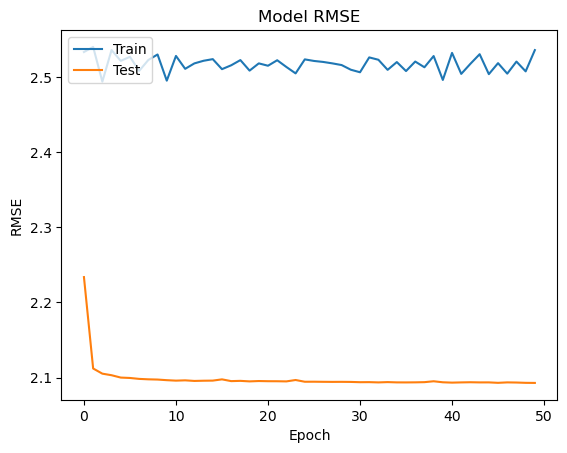

In [75]:
# plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Prediction

The prediction pipeline is:

1.  Export imagery on which to do predictions from Earth Engine in TFRecord format to a Cloud Storage bucket.
2.  Use the trained model to make the predictions.
3.  Write the predictions to a TFRecord file in a Cloud Storage.
4.  Upload the predictions TFRecord file to Earth Engine.

The following functions handle this process.  It's useful to separate the export from the predictions so that you can experiment with different models without running the export every time.

## Export Sample Imagery for Prediction

In [ ]:
def doExport(out_image_base, kernel_buffer, region):
  """Run the image export task.  Block until complete.
  """
  task = ee.batch.Export.image.toCloudStorage(
    image = image.select(BANDS),
    description = out_image_base,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + out_image_base,
    region = region.getInfo()['coordinates'],
    scale = 30,
    fileFormat = 'TFRecord',
    maxPixels = 1e10,
    formatOptions = {
      'patchDimensions': KERNEL_SHAPE,
      'kernelSize': kernel_buffer,
      'compressed': True,
      'maxFileSize': 104857600
    }
  )
  task.start()

  # Block until the task completes.
  print('Running image export to Cloud Storage...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    print('Image export completed.')

## Define Code for Running Model on Prediction Data
Modified to run on local data.

In [ ]:
def doPrediction(out_image_base, kernel_buffer):
  """Perform inference on exported imagery, upload to Earth Engine.
  """

  print('Looking for TFRecord files...')

  # # Get a list of all the files in the output bucket.
  # filesList = !gsutil ls 'gs://'{BUCKET}'/'{FOLDER}
  # Get a list of all local files in /data/unet-mini
  filesList = !ls {HOME_PATH}{DATA_PATH}{FOLDER}

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if out_image_base in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(imageFilesList)
  print('here I am')
  print(jsonFile)

  import json
  # Load the contents of the mixer file to a JSON object.
  # jsonText = !{GCLOUD_PATH}gsutil cat {jsonFile}  
  # jsonText = !cat '/home/isly9493/csci5922/proj/data/viirs-usa/FCNN_demo_beijing_384_mixer.json'
  jsonText = !cat {HOME_PATH}{DATA_PATH}{FOLDER}{jsonFile}
  print(jsonText)
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']



  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32)
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

  # append absolute path to imageFilesList
  imageFilesList = [HOME_PATH + DATA_PATH + FOLDER + f for f in imageFilesList]
  print(imageFilesList)
  
  # Create a dataset from the TFRecord file(s) in Cloud Storage.
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)

  # print(imageDataset)

  # Perform inference.
  print('Running predictions...')
  predictions = m.predict(imageDataset, steps=patches, verbose=1)
  # print(predictions[0])
  return predictions

In [ ]:

def writePredictions(predictions, out_image_base, kernel_buffer):
  print('Writing predictions...')
  out_image_file = 'gs://' + BUCKET + '/' + FOLDER + out_image_base + '.TFRecord'
  # out_image_file = '/home/isly9493/csci5922/proj/data/unet-mini/' + out_image_base + '.TFRecord'

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)
  
  
  writer = tf.io.TFRecordWriter(out_image_file)
  patches = 0
  for predictionPatch in predictions:
    print('Writing patch ' + str(patches) + '...')
    predictionPatch = predictionPatch[
        x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

    # Create an example.
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'impervious': tf.train.Feature(
            float_list=tf.train.FloatList(
              value=predictionPatch.flatten()
            )
          )
        }
      )
    )
    # Write the example.
    writer.write(example.SerializeToString())
    patches += 1

  print('Done for looping.')
  writer.close()


In [ ]:
def uploadPredictionsToEE(out_image_base, user_folder):
  # Start the upload.
  print('Uploading to Google Earth Egnine...')
  
  # define file paths
  out_image_file = 'gs://' + BUCKET + '/' + FOLDER + '/' + out_image_base + '.TFRecord'
  out_image_asset = user_folder + '/' + out_image_base
  jsonFile = 'gs://' + BUCKET + '/' + FOLDER + '/' + 'FCNN_demo_beijing_384_mixer.json'
  # jsonFile = '/home/isly9493/csci5922/proj/data/unet-mini/FCNN_demo_beijing_384_mixer.json'
  
  print('out_image_asset: ', out_image_asset)
  print('out_image_file: ', out_image_file)
  print('jsonFile: ', jsonFile)
  
  # upload file to google earth engine from gcs
  # !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}
  !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}

Now there's all the code needed to run the prediction pipeline, all that remains is to specify the output region in which to do the prediction, the names of the output files, where to put them, and the shape of the outputs.  In terms of the shape, the model is trained on 256x256 patches, but can work (in theory) on any patch that's big enough with even dimensions ([reference](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)).  Because of tile boundary artifacts, give the model slightly larger patches for prediction, then clip out the middle 256x256 patch.  This is controlled with a kernel buffer, half the size of which will extend beyond the kernel buffer.  For example, specifying a 128x128 kernel will append 64 pixels on each side of the patch, to ensure that the pixels in the output are taken from inputs completely covered by the kernel.

### Specify Region and Outputs for Prediction

In [ ]:
# Output assets folder: YOUR FOLDER
user_folder = 'projects/'+GCS_PROJECT+'/assets' # INSERT YOUR FOLDER HERE.

# Base file name to use for TFRecord files and assets.
bj_image_base = 'FCNN_demo_beijing_384_'
# Half this will extend on the sides of each patch.
bj_kernel_buffer = [128, 128]
# Beijing
bj_region = ee.Geometry.Polygon(
        [[[115.9662455210937, 40.121362012835235],
          [115.9662455210937, 39.64293313749715],
          [117.01818643906245, 39.64293313749715],
          [117.01818643906245, 40.121362012835235]]], None, False)

In [ ]:
# Run the export.
doExport(bj_image_base, bj_kernel_buffer, bj_region)

In [ ]:
# copy the file from cloud storage to local
!{GCLOUD_PATH}gsutil -m cp \
  "gs://csci5922-proj/viirs-usa/FCNN_demo_beijing_384_00000.tfrecord.gz" \
  "gs://csci5922-proj/viirs-usa/FCNN_demo_beijing_384_00001.tfrecord.gz" \
  "gs://csci5922-proj/viirs-usa/FCNN_demo_beijing_384_00002.tfrecord.gz" \
  "gs://csci5922-proj/viirs-usa/FCNN_demo_beijing_384_00003.tfrecord.gz" \
  "gs://csci5922-proj/viirs-usa/FCNN_demo_beijing_384_00004.tfrecord.gz" \
  "gs://csci5922-proj/viirs-usa/FCNN_demo_beijing_384_mixer.json" \
  "/home/isly9493/csci5922/proj/data/viirs-usa/"


In [76]:
# Run the prediction.
predictions = doPrediction(bj_image_base, bj_kernel_buffer)


Looking for TFRecord files...
['FCNN_demo_beijing_384_00000.tfrecord.gz',
 'FCNN_demo_beijing_384_00001.tfrecord.gz',
 'FCNN_demo_beijing_384_00002.tfrecord.gz',
 'FCNN_demo_beijing_384_00003.tfrecord.gz',
 'FCNN_demo_beijing_384_00004.tfrecord.gz']
here I am
FCNN_demo_beijing_384_mixer.json
['{', '  "projection": {', '    "crs": "EPSG:4326",', '    "affine": {', '      "doubleMatrix": [2.6949458523585647E-4, 0.0, 115.9662149728414, 0.0, -2.6949458523585647E-4, 40.122623344499544]', '    }', '  },', '  "patchDimensions": [256, 256],', '  "patchesPerRow": 15,', '  "totalPatches": 90', '}']
{'patchDimensions': [256, 256],
 'patchesPerRow': 15,
 'projection': {'affine': {'doubleMatrix': [0.00026949458523585647,
                                            0.0,
                                            115.9662149728414,
                                            0.0,
                                            -0.00026949458523585647,
                                            40.12262

In [77]:
# Write the predictions.
writePredictions(predictions, bj_image_base, bj_kernel_buffer)

Writing predictions...
Writing patch 0...
Writing patch 1...
Writing patch 2...
Writing patch 3...
Writing patch 4...
Writing patch 5...
Writing patch 6...
Writing patch 7...
Writing patch 8...
Writing patch 9...
Writing patch 10...
Writing patch 11...
Writing patch 12...
Writing patch 13...
Writing patch 14...
Writing patch 15...
Writing patch 16...
Writing patch 17...
Writing patch 18...
Writing patch 19...
Writing patch 20...
Writing patch 21...
Writing patch 22...
Writing patch 23...
Writing patch 24...
Writing patch 25...
Writing patch 26...
Writing patch 27...
Writing patch 28...
Writing patch 29...
Writing patch 30...
Writing patch 31...
Writing patch 32...
Writing patch 33...
Writing patch 34...
Writing patch 35...
Writing patch 36...
Writing patch 37...
Writing patch 38...
Writing patch 39...
Writing patch 40...
Writing patch 41...
Writing patch 42...
Writing patch 43...
Writing patch 44...
Writing patch 45...
Writing patch 46...
Writing patch 47...
Writing patch 48...
Writing

In [78]:
# upload to earth engine
uploadPredictionsToEE(bj_image_base, user_folder)

Uploading to Google Earth Egnine...
out_image_asset:  projects/master-thesis-ilg/assets/FCNN_demo_beijing_384_
out_image_file:  gs://csci5922-proj/viirs-usa//FCNN_demo_beijing_384_.TFRecord
jsonFile:  gs://csci5922-proj/viirs-usa//FCNN_demo_beijing_384_mixer.json
Started upload task with ID: DEFIVQWVPOBVJY5YLXXW6R5R


# Display the output

One the data has been exported, the model has made predictions and the predictions have been written to a file, and the image imported to Earth Engine, it's possible to display the resultant Earth Engine asset.  Here, display the impervious area predictions over Beijing, China.

In [79]:
map = folium.Map(location=[39.898, 116.5097], zoom_start=11)

# actual viirs
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad').filterDate('2021-01-01', '2022-12-31').median().divide(60).float()
actual_image = viirs.clip(bj_region)
mapid = viirs.getMapId({'min': 0, 'max': 1}) # normally max 1.0
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='viirs dnb',
  ).add_to(map)

# prediction
out_image = ee.Image(user_folder + '/' + bj_image_base)
mapid = out_image.getMapId({'min': 0, 'max': 1})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='predicted nightlights',
  ).add_to(map)


# difference
diff = out_image.subtract(actual_image)
mapid = diff.getMapId({'min': -0.5, 'max': 0.5, 'palette': ['FF0000', '000000', '00FF00']})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='difference',
  ).add_to(map)

# visualize the map
map.add_child(folium.LayerControl())
map